In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
from result_analysis import show_trade_off
import os
import imageio

In [23]:
experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'biodeg_V25', 
                'credit_A1', 'sick_referral_source_other', 'vote_immigration', 'ads_local', 'churn_voice_mail_plan']

noise_types = [ 'random', 'flip', 'bias', 'balanced_bias']

algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

nr = [i/10 for i in range(1, 10)]

colors = {'PL':'tab:blue', 
          'STC':'tab:orange', 
          'CC':'tab:green', 
          'HLNC':'tab:red', 
          'OBNC':'tab:purple', 
          'BE':'tab:brown'}

In [3]:
runs = {}
for noise_type in noise_types:
    runs[noise_type] = {}
    for exp in experiments:
        for alg in algorithms:
            runs[noise_type][f'{exp}_{alg}'] = pd.read_csv(f'../noiseinjection_results/{noise_type}/{exp}_{alg}.csv')

In [10]:
def metric_across_datasets(noise_type, metric):
    fig = plt.figure(figsize=(20, 10))
    axs = fig.subplots(3, 3, sharex=True, sharey=True)

    for i in range(len(experiments)):
        exp = experiments[i]
        row = i // 3
        col = i % 3

        for alg in algorithms:
            run = runs[noise_type][f'{exp}_{alg}']

            values = run.loc[(run['tags.test_set'] == 'original') 
                    & (run['tags.train_set'] == 'corrected')].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{metric}'].values
            
            axs[row, col].plot([i/10 for i in range(1, 10)], values, label=alg)

        axs[row, col].set_title(exp)
        if row == 2:
            axs[row, col].set_xlabel('Noise Rate')
        if col == 0:
            axs[row, col].set_ylabel(metric)

    axs[row, col].legend()
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()
        

# AUC difference metric

### Random noise

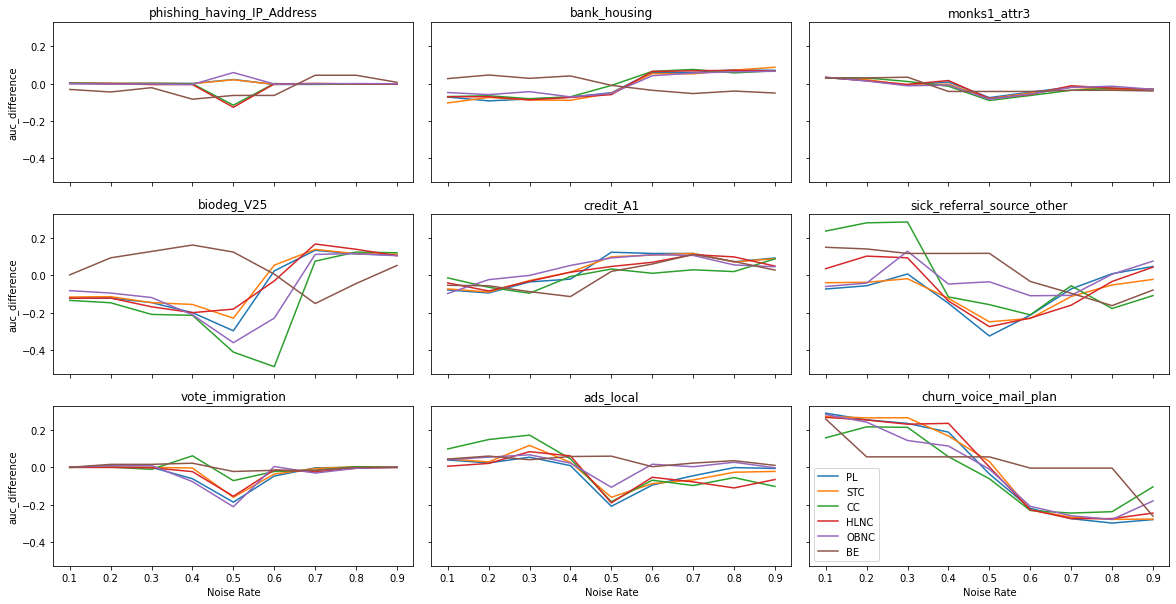

In [11]:
metric_across_datasets('random', 'auc_difference')

### Label flipping

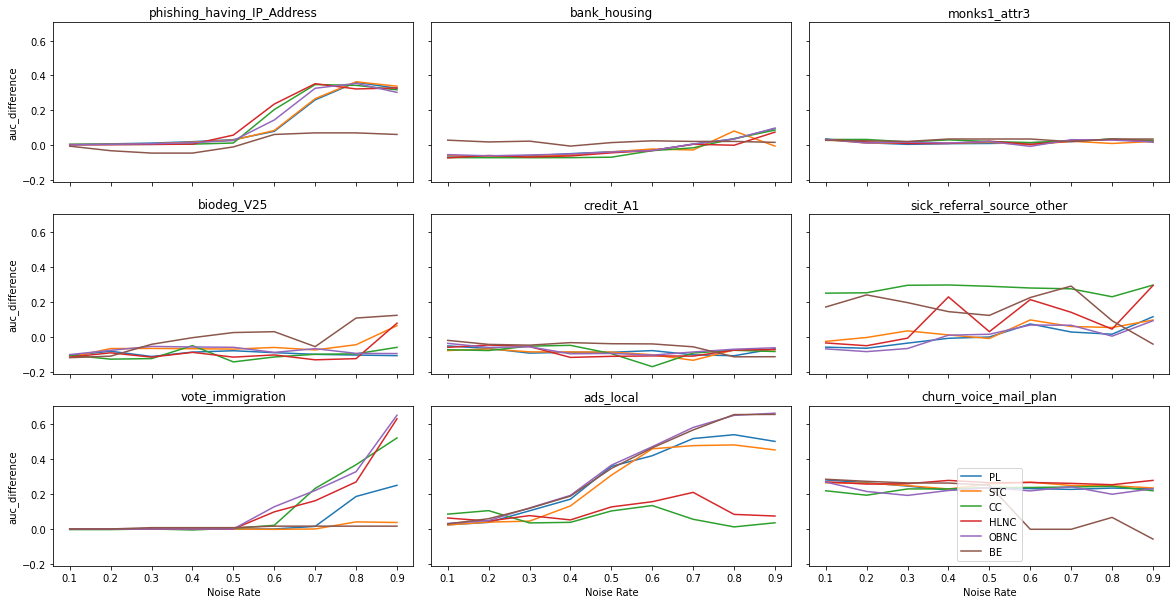

In [13]:
metric_across_datasets('flip', 'auc_difference')

### Positive Bias

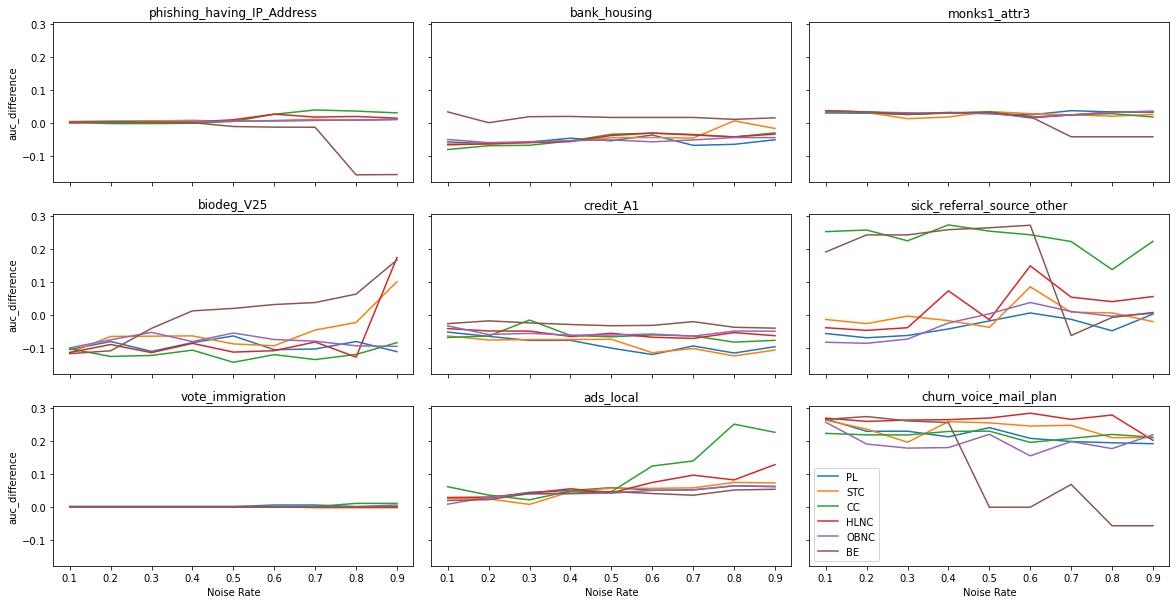

In [14]:
metric_across_datasets('bias', 'auc_difference')

### Balanced bias

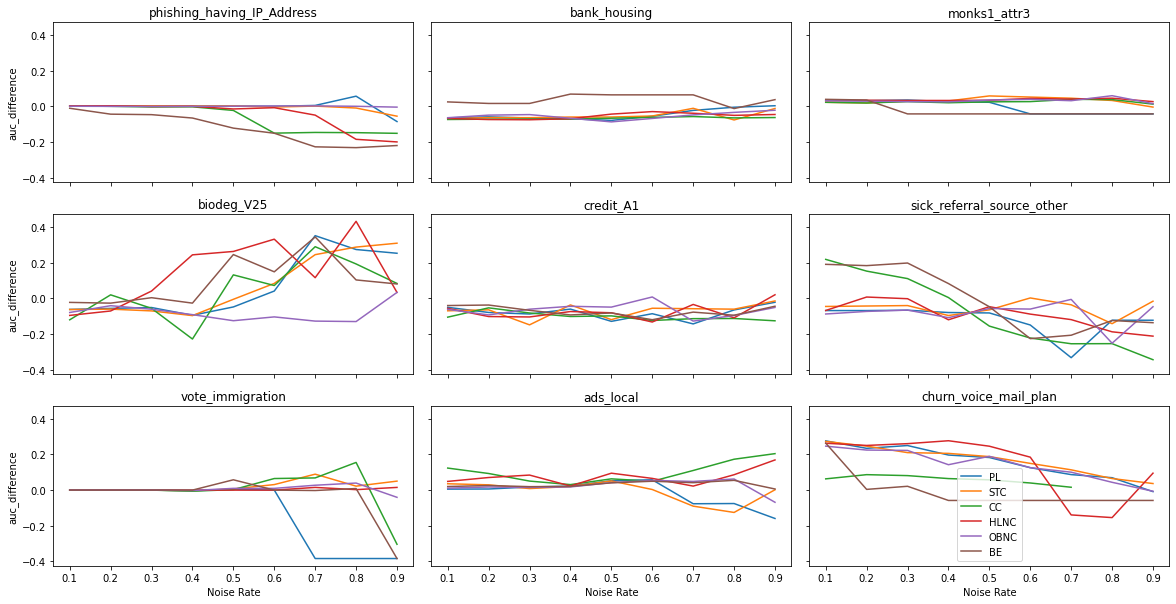

In [15]:
metric_across_datasets('balanced_bias', 'auc_difference')

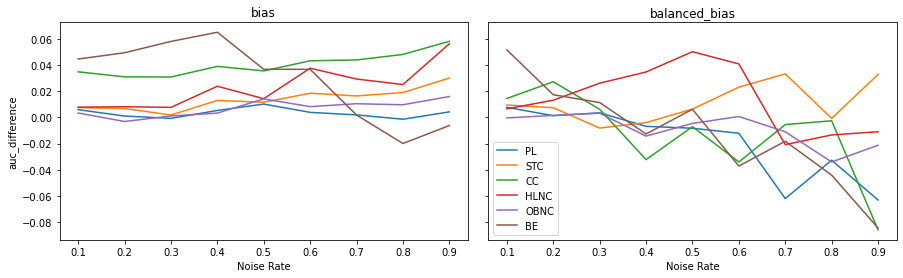

In [124]:
metric = 'auc_difference'
noise_type = 'random'

fig = plt.figure(figsize=(15, 4))
axs = fig.subplots(1, 2, sharex=True, sharey=True)
i = 0

for noise_type in ['bias', 'balanced_bias']:
    values = pd.DataFrame(columns=[i/10 for i in range(1, 10)])

    for alg in algorithms:
        for exp in experiments:
            run = runs[noise_type][f'{exp}_{alg}']

            values.loc[exp] = run.loc[(run['tags.test_set'] == 'original') 
                    & (run['tags.train_set'] == 'corrected')].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{metric}'].values
            
        axs[i].plot(values.columns, values.mean(), label=alg)

    axs[i].set_title(noise_type)
    axs[i].set_xlabel('Noise Rate')
    if i == 0:
        axs[i].set_ylabel(metric)

    i += 1

plt.subplots_adjust(wspace=0.05, hspace=0.15)
plt.legend()
plt.show()

# Using different thresholds

In [52]:
def show_thresh_differences(noise_type, metric):
    fig = plt.figure(figsize=(15, 6))
    axs = fig.subplots(2, 3, sharex=True, sharey=True)

    for i in range(len(algorithms)):
        alg = algorithms[i]
        row = i // 3
        col = i % 3

        for thresh in [0.8, 0.5, 0.2]:
            values = pd.DataFrame(columns=nr)

            for exp in experiments:
                run = runs[noise_type][f'{exp}_{alg}']
                values.loc[exp] = run.loc[(run['tags.test_set'] == 'original') & (run['tags.train_set'] == 'corrected')].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{metric}_{thresh}'].values
            
            if thresh == 0.5:
                c = colors[alg]
            elif thresh == 0.2:
                original = to_rgb(colors[alg])
                c = (min(original[0] + 0.2, 1), min(original[1] + 0.2, 1), min(original[2] + 0.2, 1))
            else:
                original = to_rgb(colors[alg])
                c = (max(original[0] - 0.2, 0), max(original[1] - 0.2, 0), max(original[2] - 0.2, 0))
            axs[row, col].plot(nr, values.mean(), label=f'threshold: {thresh}', color=c)

        if row == 1:
            axs[row, col].set_xlabel('Noise rate')
        if col == 0:
            axs[row, col].set_ylabel(metric)
        axs[row, col].set_title(f'algorithm: {alg}')
        axs[row, col].legend()
    plt.suptitle(f'Noise type: {noise_type}, metric: {metric}', fontsize=16)
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    plt.show()

In [76]:
def compare_algs_over_thresholds(noise_type, metric):
    fig = plt.figure(figsize=(20, 4))
    axs = fig.subplots(1, 3, sharex=True, sharey=True)
    i = 0

    for thresh in [0.2, 0.5, 0.8]:
        for alg in algorithms:
            values = pd.DataFrame(columns=nr)

            for exp in experiments:
                run = runs[noise_type][f'{exp}_{alg}']
                values.loc[exp] = run.loc[(run['tags.test_set'] == 'original') & (run['tags.train_set'] == 'corrected')].sort_values(by='params.noise_rate', ascending=True)[f'metrics.{metric}_{thresh}'].values
            
            axs[i].plot(nr, values.mean(), label=alg, color=colors[alg])
            axs[i].set_title(f'Threshold: {thresh}')
            axs[i].set_xlabel('Noise rate')
            if i == 0:
                axs[i].set_ylabel(metric)
        i += 1

    axs[2].legend()
    plt.suptitle(f'Noise type: {noise_type}, metric: {metric}', fontsize=14, y=1.01)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

## Accuracy

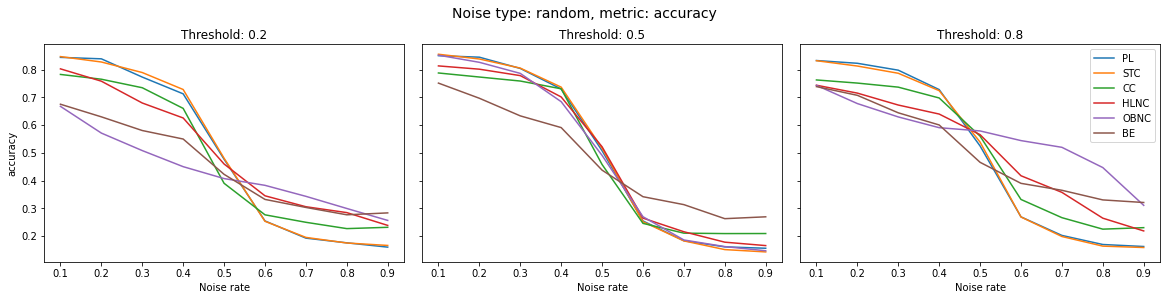

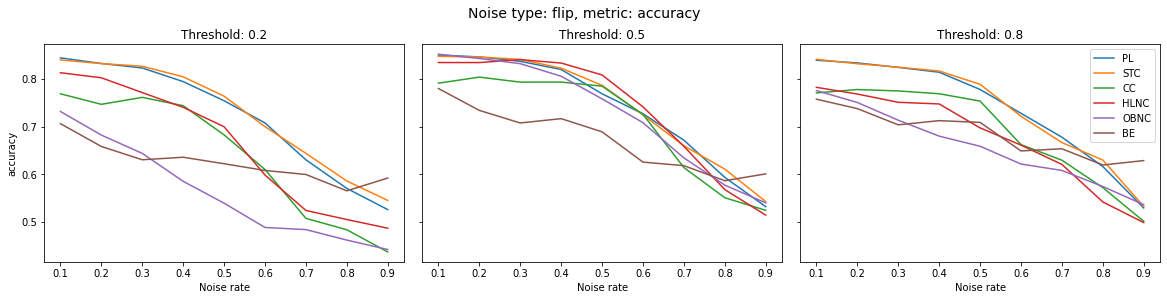

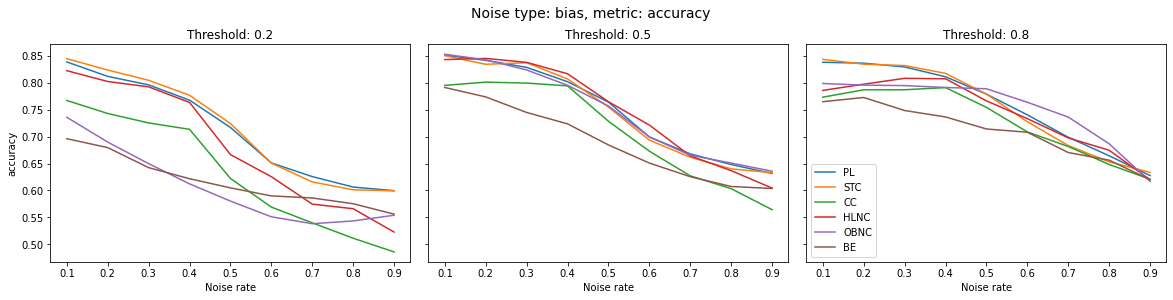

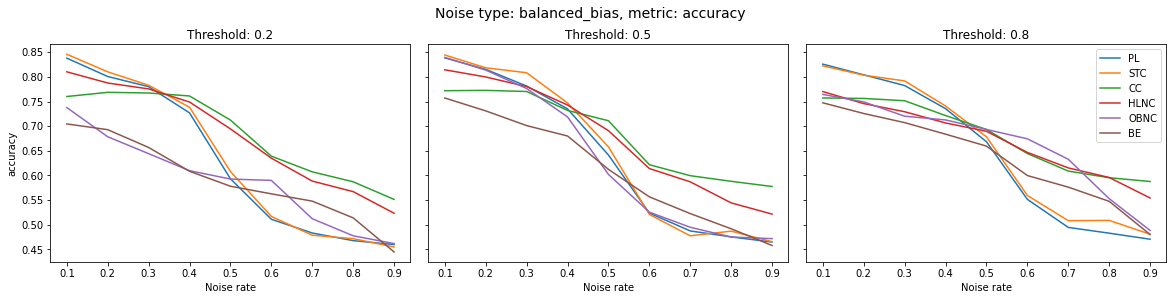

In [77]:
for noise_type in noise_types:
    compare_algs_over_thresholds(noise_type, 'accuracy')

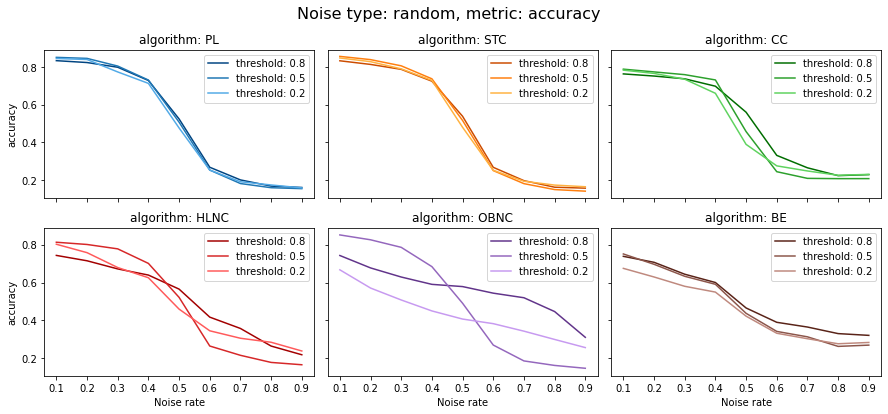

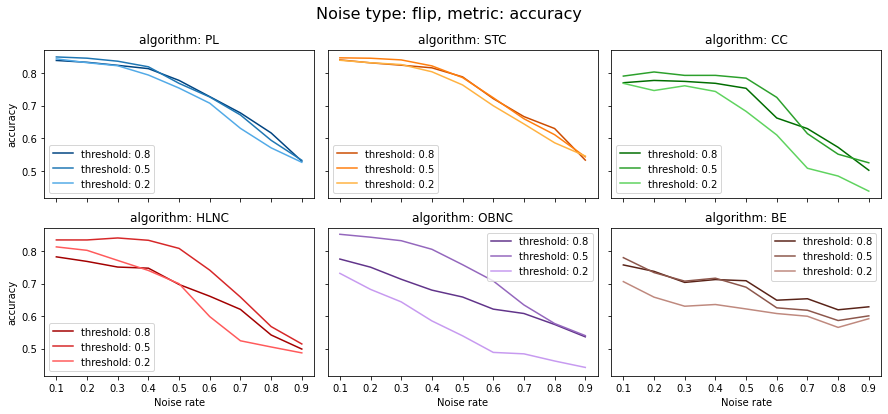

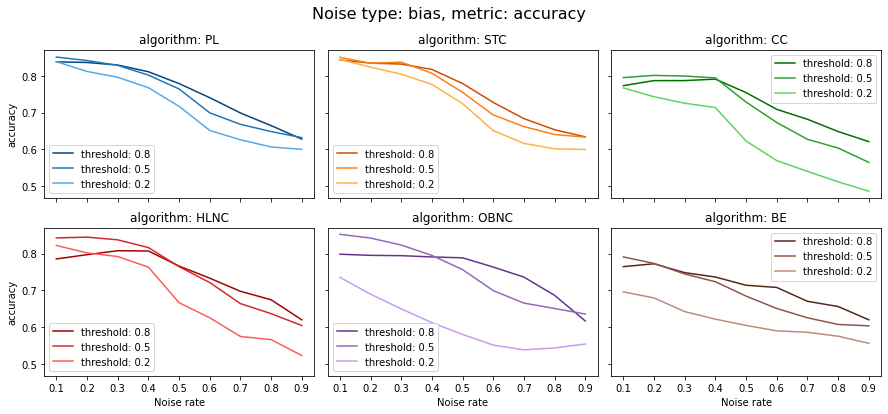

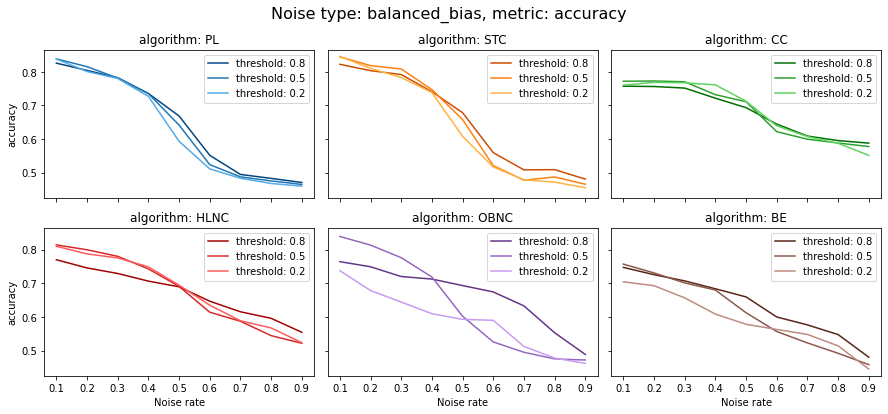

In [53]:
for noise_type in noise_types:
    show_thresh_differences(noise_type, 'accuracy')

## Predictive Equality

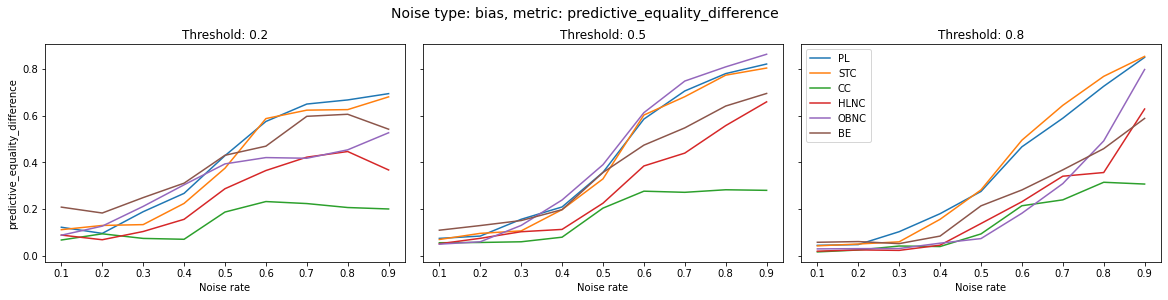

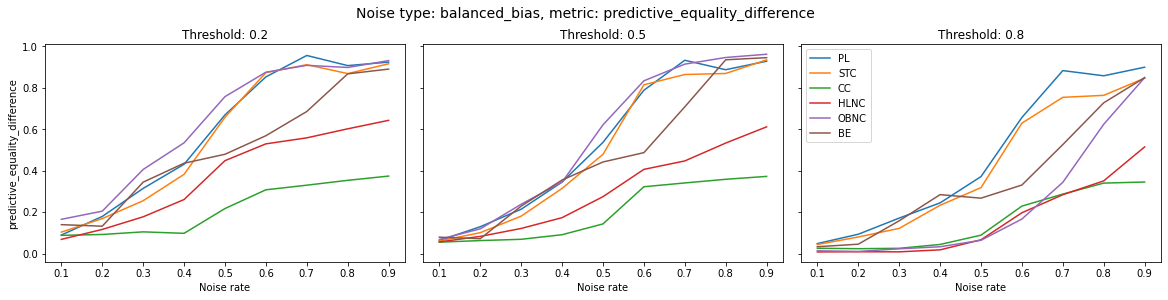

In [79]:
for noise_type in ['bias', 'balanced_bias']:
    compare_algs_over_thresholds(noise_type, 'predictive_equality_difference')

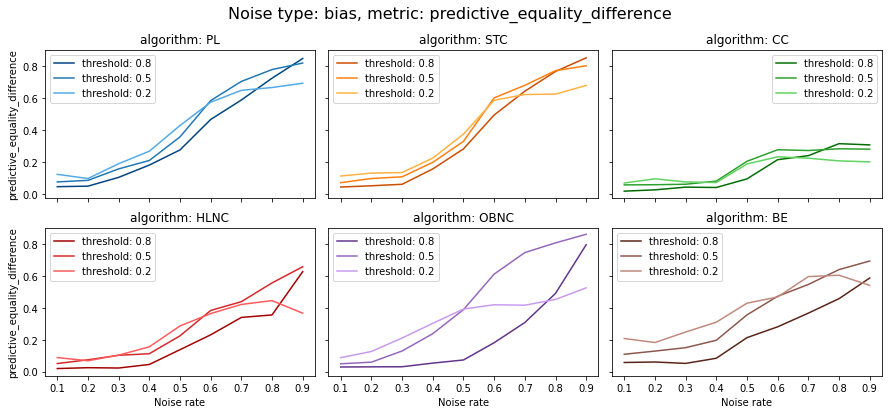

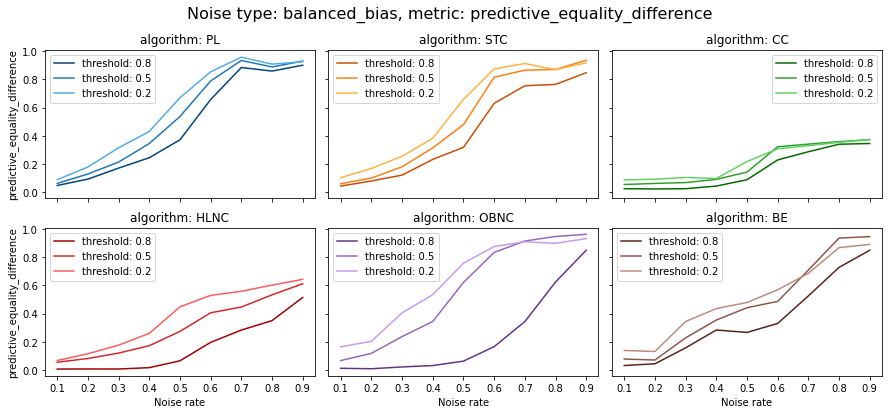

In [56]:
for noise_type in ['bias', 'balanced_bias']:
    show_thresh_differences(noise_type, 'predictive_equality_difference')

## Equalized Odds

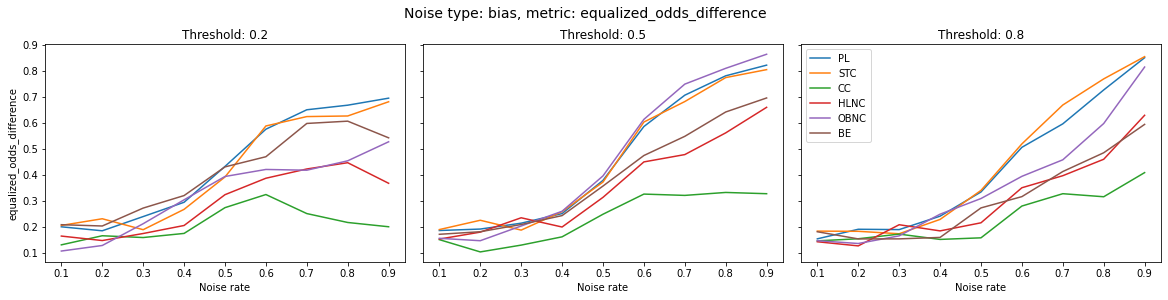

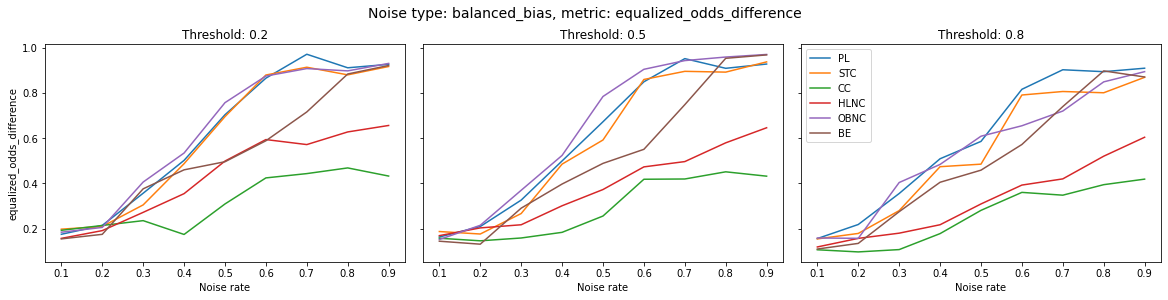

In [80]:
for noise_type in ['bias', 'balanced_bias']:
    compare_algs_over_thresholds(noise_type, 'equalized_odds_difference')

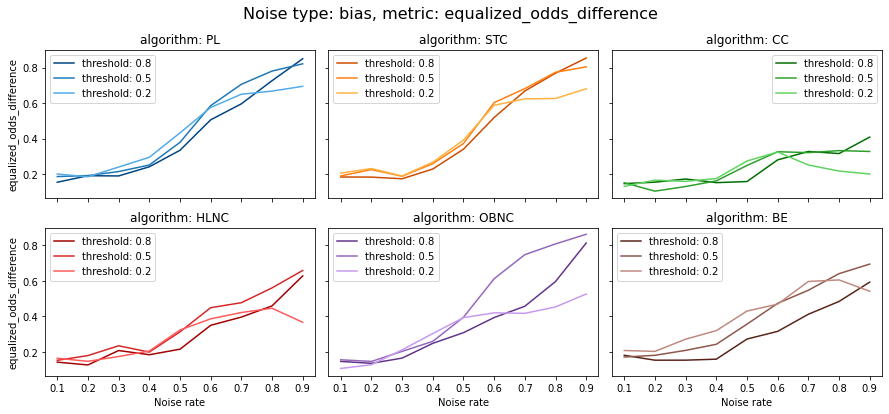

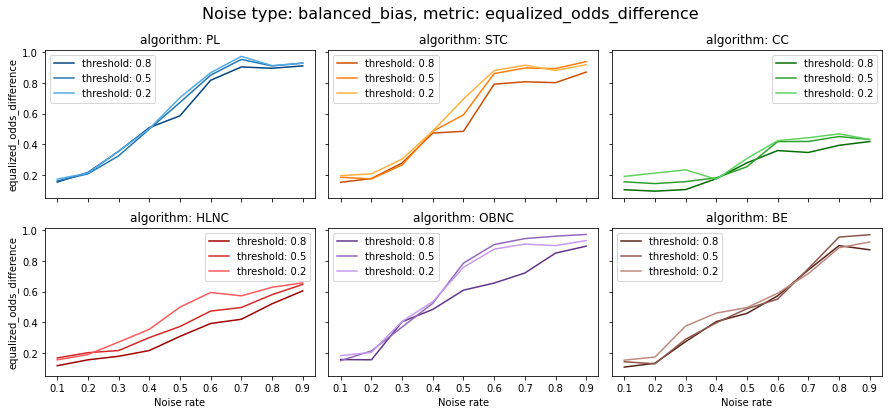

In [57]:
for noise_type in ['bias', 'balanced_bias']:
    show_thresh_differences(noise_type, 'equalized_odds_difference')

## Demographic Parity

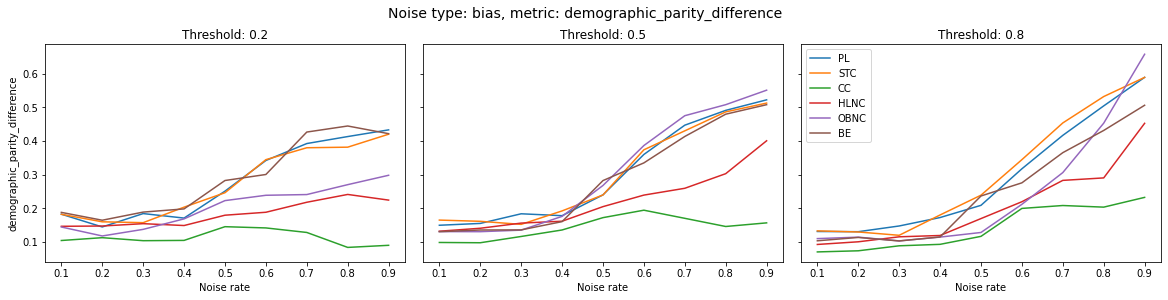

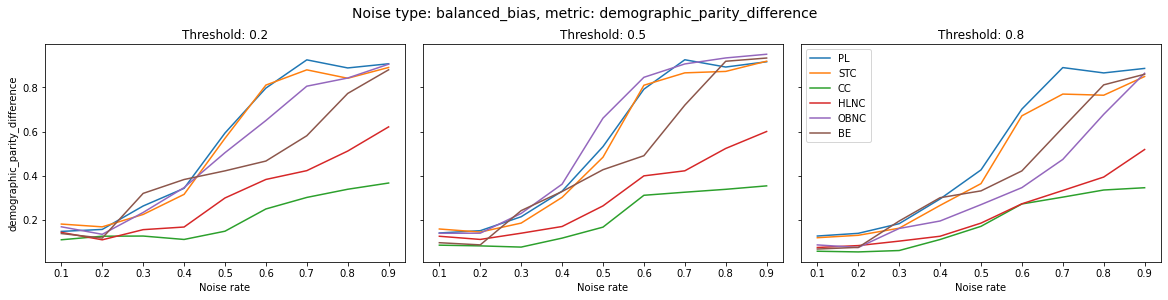

In [81]:
for noise_type in ['bias', 'balanced_bias']:
    compare_algs_over_thresholds(noise_type, 'demographic_parity_difference')

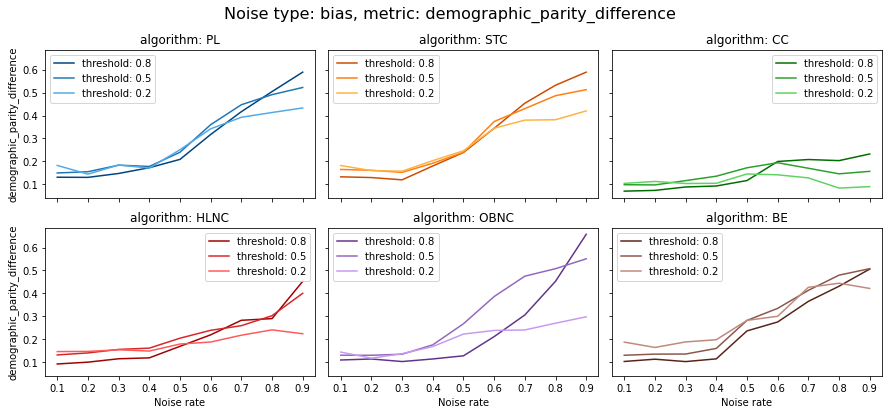

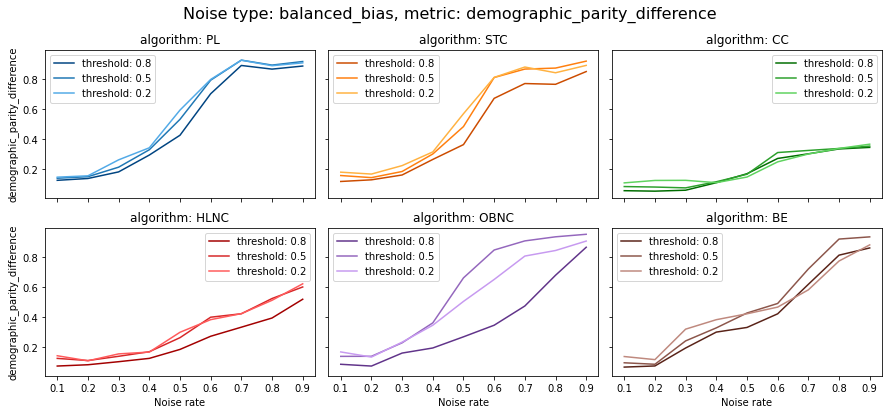

In [58]:
for noise_type in ['bias', 'balanced_bias']:
    show_thresh_differences(noise_type, 'demographic_parity_difference')

## Equal Opportunity

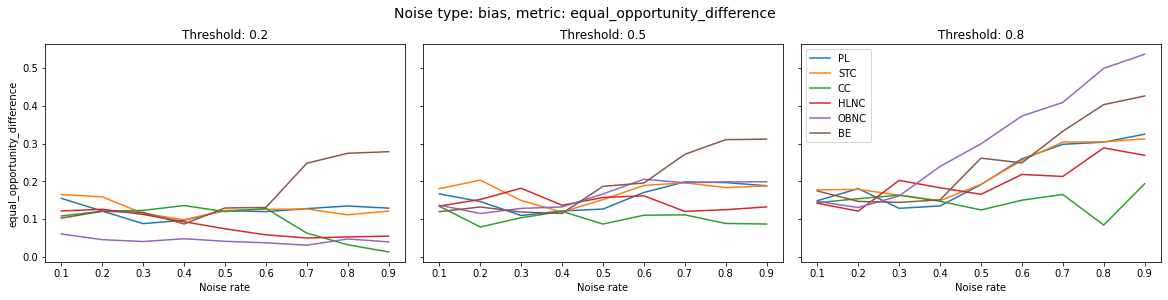

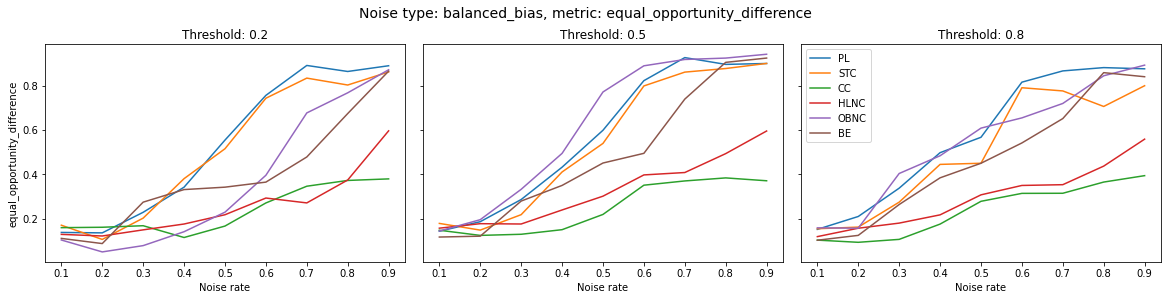

In [82]:
for noise_type in ['bias', 'balanced_bias']:
    compare_algs_over_thresholds(noise_type, 'equal_opportunity_difference')

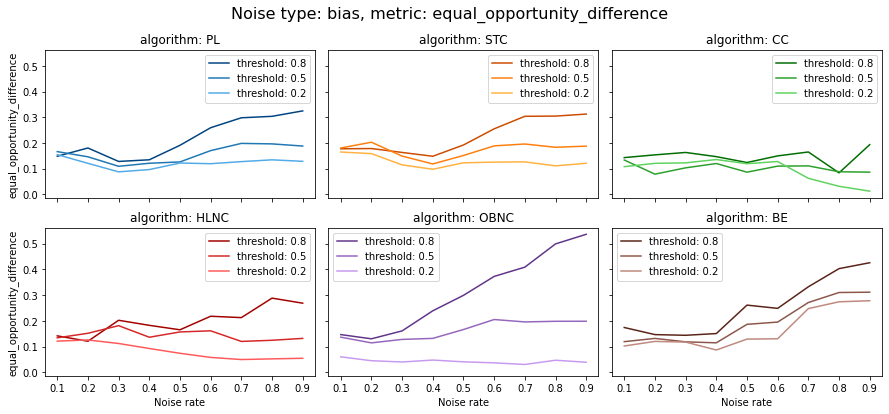

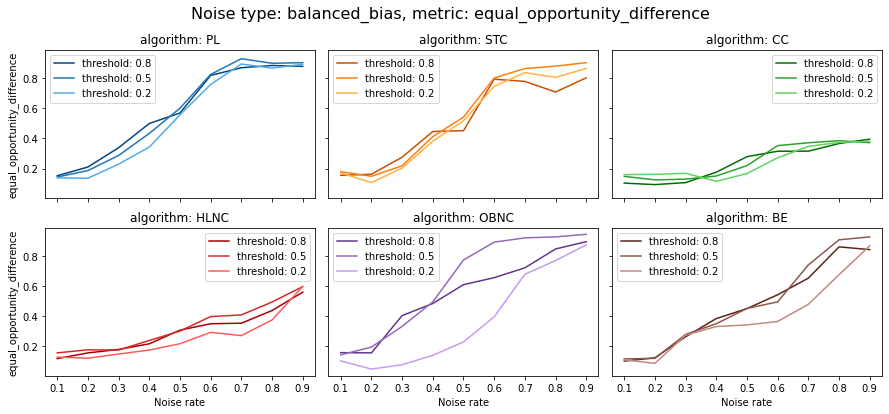

In [59]:
for noise_type in ['bias', 'balanced_bias']:
    show_thresh_differences(noise_type, 'equal_opportunity_difference')

# Trade-Offs

In [106]:
def threshold_trade_off(noise_type, pred_metric, fair_metric, xlimit, ylimit):
    for noise_rate in nr:
        fig = plt.figure(figsize=(20, 4))
        axs = fig.subplots(1, 3, sharex=True, sharey=True)
        i = 0
        for thresh in [0.2, 0.5, 0.8]:
            show_trade_off(noise_type, pred_metric, fair_metric, 'original', noise_rate, axs[i], algorithms, experiments, runs, xlimit, ylimit, thresh)
            axs[i].set_title(f'Threshold: {thresh}')
            i += 1

        axs[2].legend()
        plt.suptitle(f'Noise rate: {noise_rate}', fontsize=16, y=1.01)
        plt.subplots_adjust(wspace=0.07)

        path = f'thresh_plots/{noise_type}_{pred_metric}_{fair_metric}'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(f'{path}/{int(noise_rate*10)}.png', bbox_inches='tight')

        plt.show()

In [107]:
def create_gif(noise_type, pred_metric, fair_metric, xlimit, ylimit):
    threshold_trade_off(noise_type, pred_metric, fair_metric, xlimit, ylimit)

    images = []
    path = f'thresh_plots/{noise_type}_{pred_metric}_{fair_metric}'
    for i in range(1, 10):
        images.append(imageio.imread(f'{path}/{i}.png'))
    imageio.mimsave(f'{path}.gif', images, format='GIF', duration=0.3)

### Positive bias

In [ ]:
create_gif('bias', 'accuracy', 'equal_opportunity_difference', (0, 0.6), (0.4, 1))

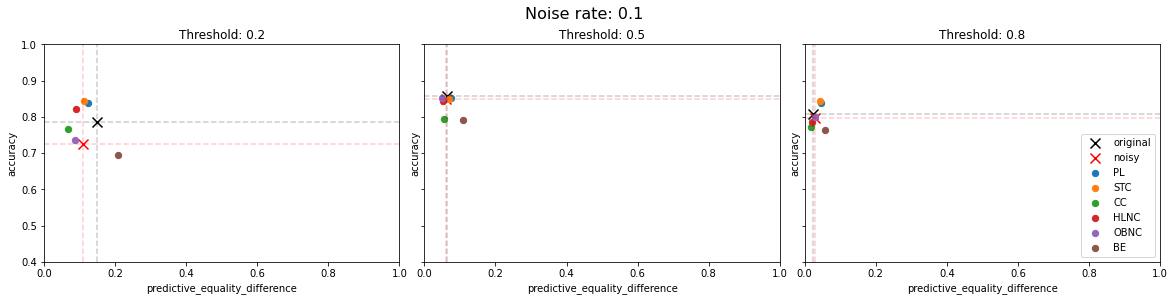

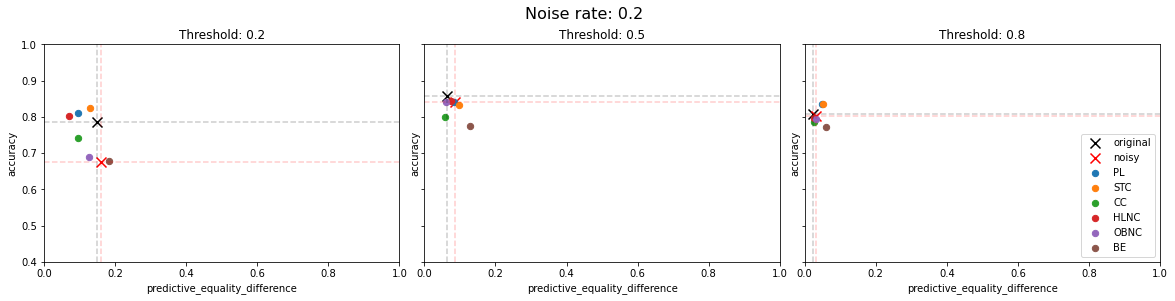

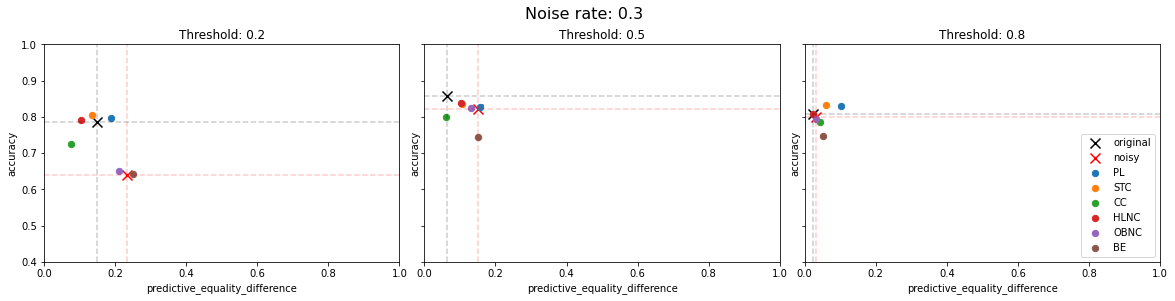

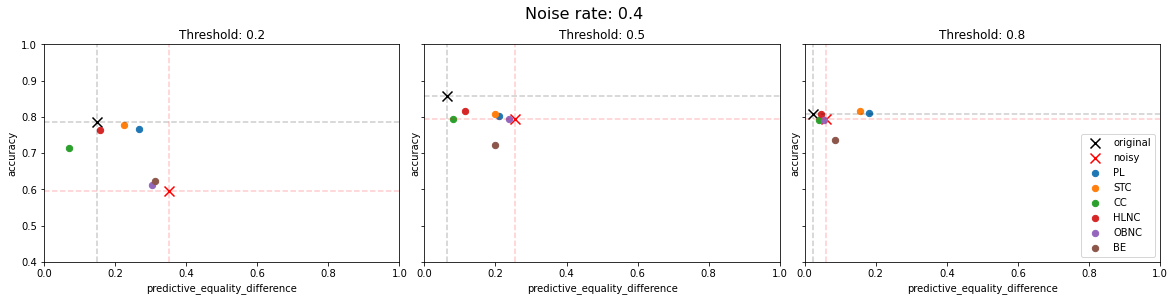

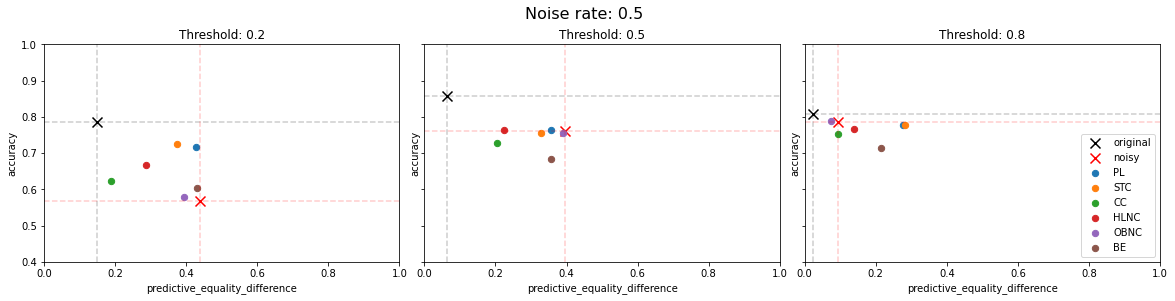

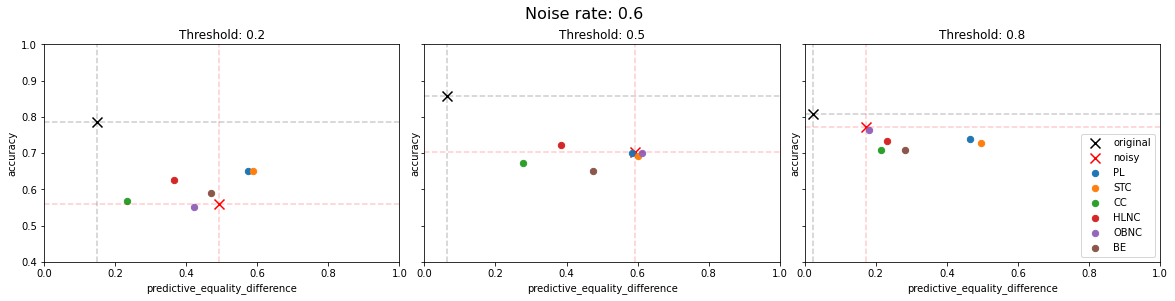

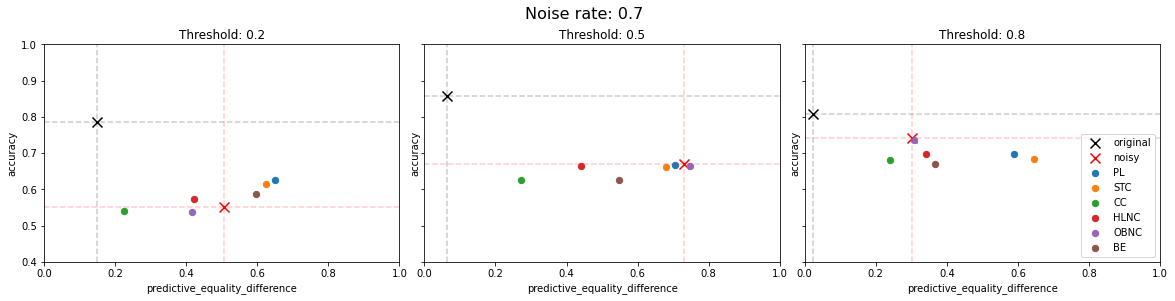

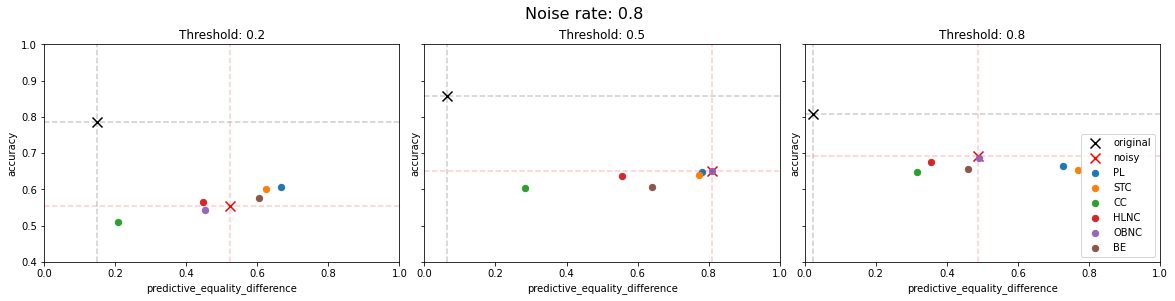

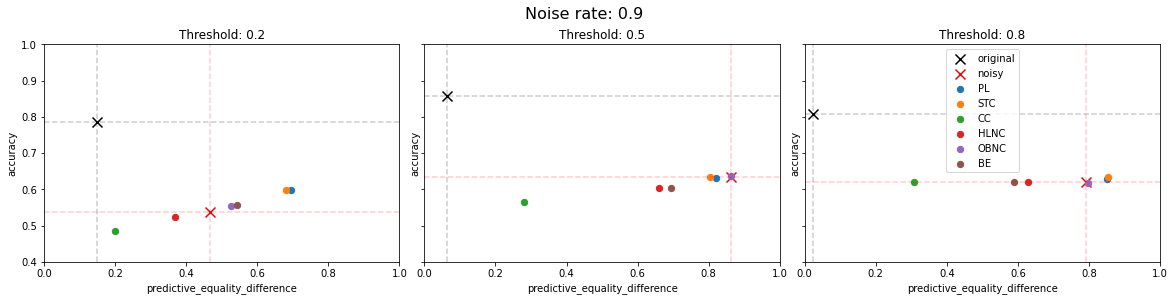

In [110]:
create_gif('bias', 'accuracy', 'predictive_equality_difference', (0, 1), (0.4, 1))

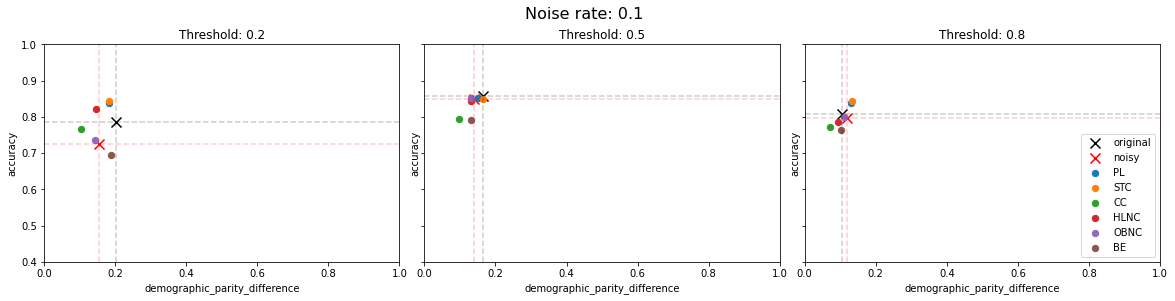

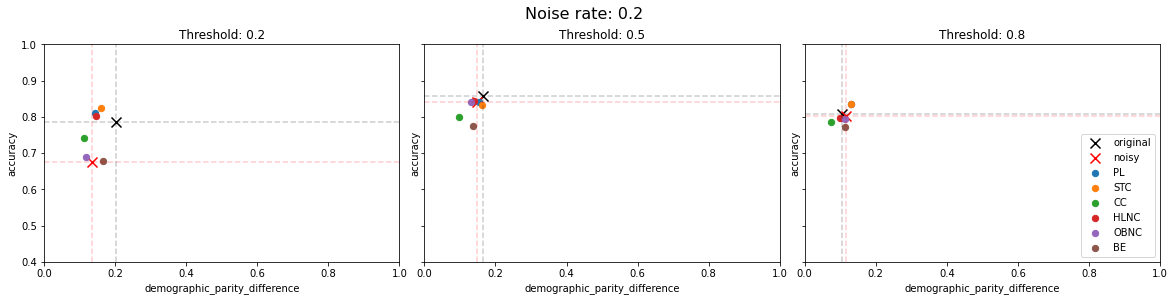

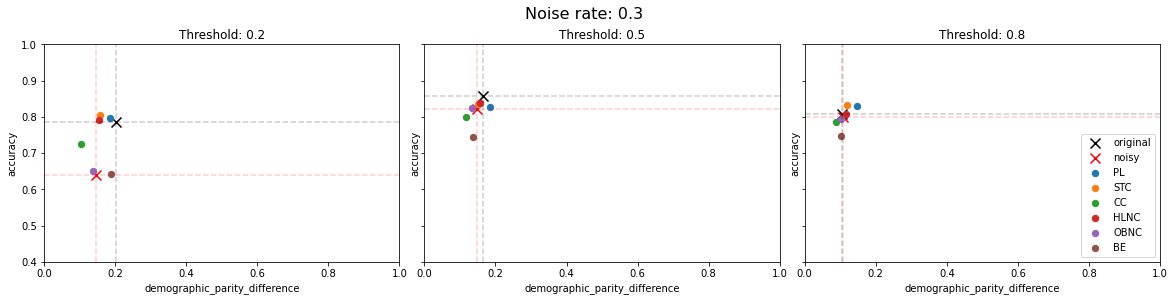

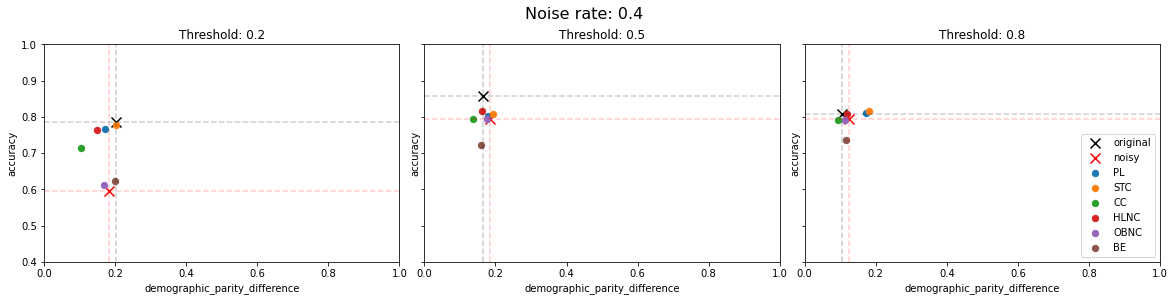

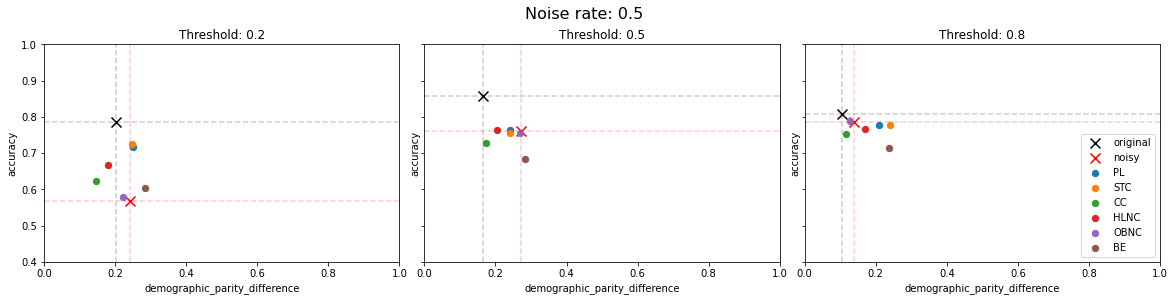

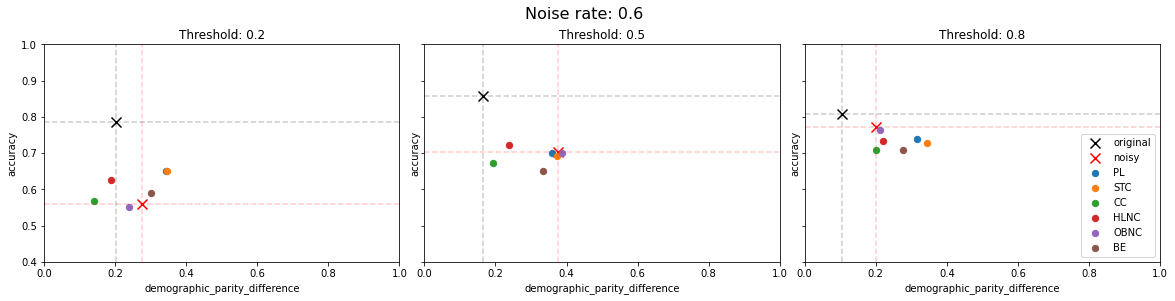

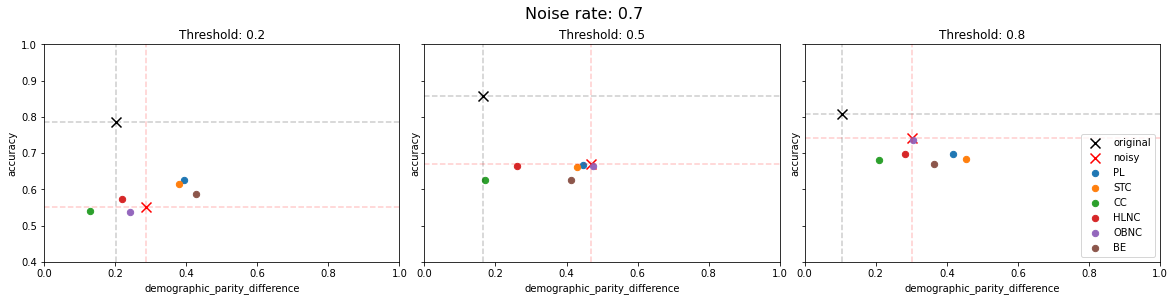

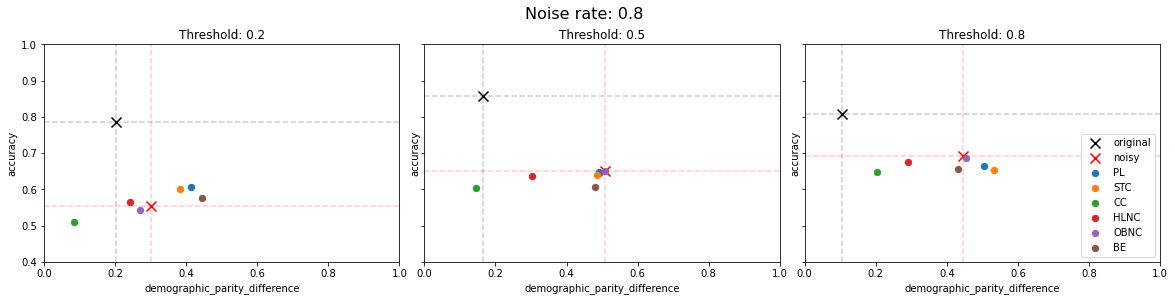

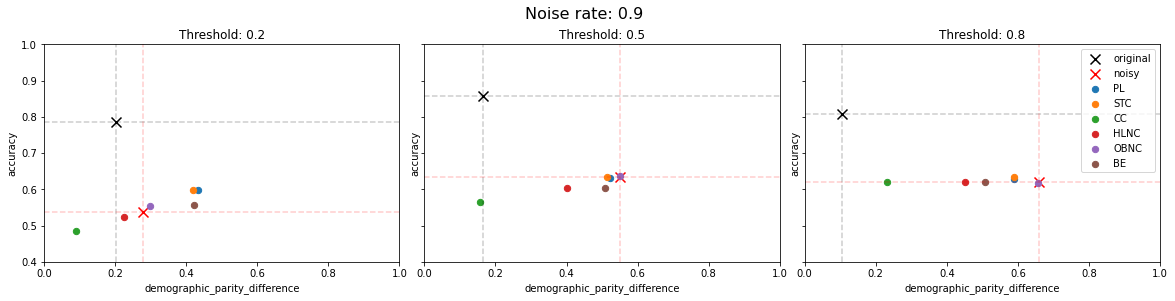

In [111]:
create_gif('bias', 'accuracy', 'demographic_parity_difference', (0, 1), (0.4, 1))

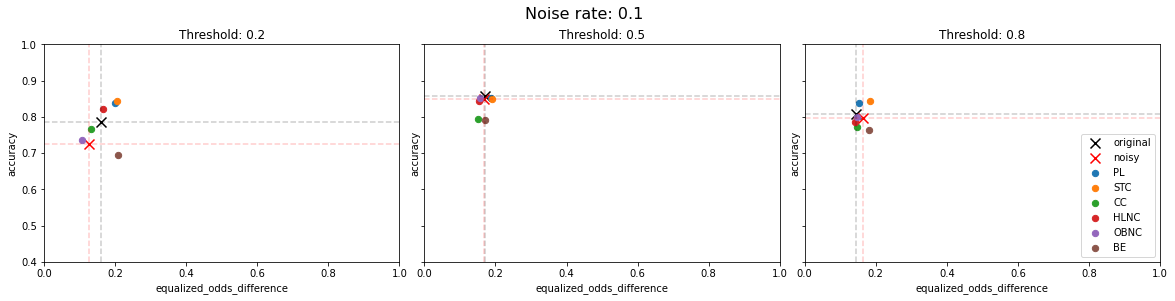

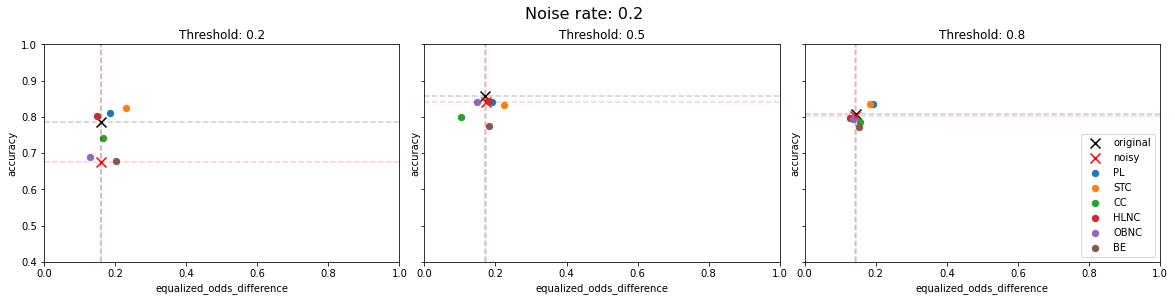

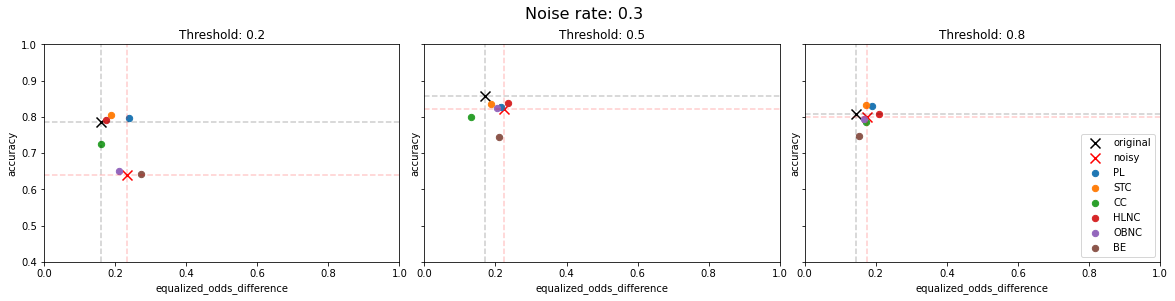

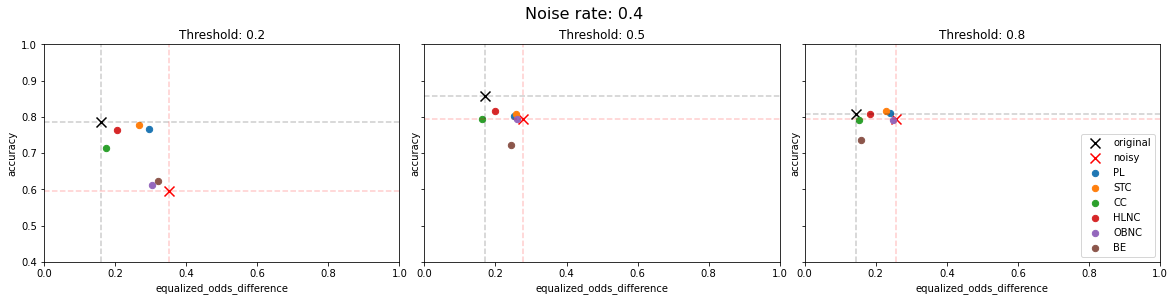

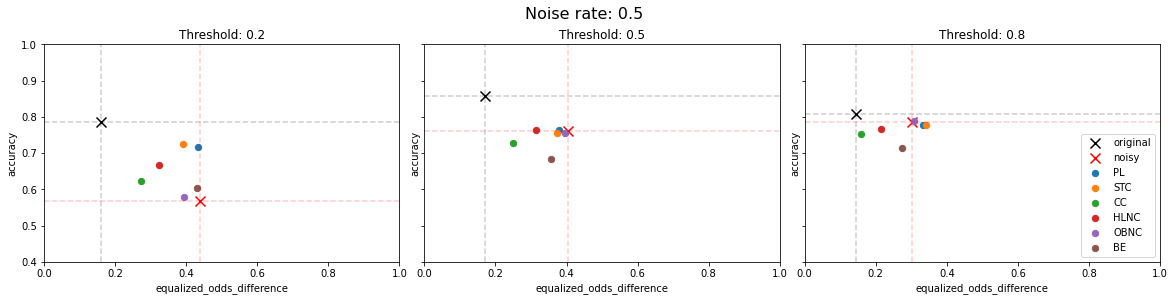

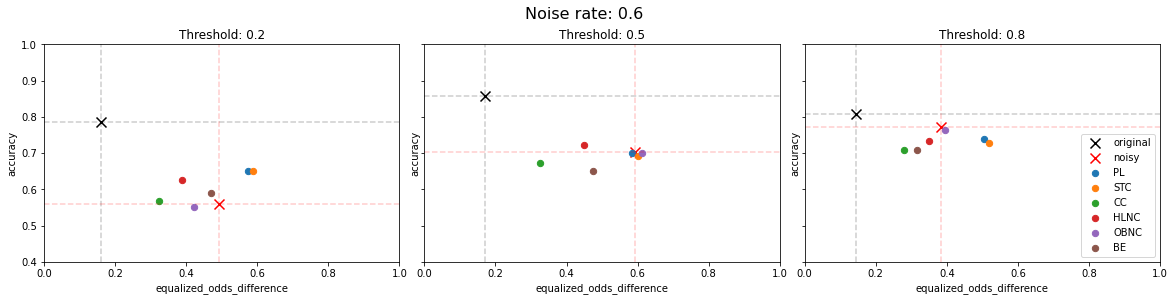

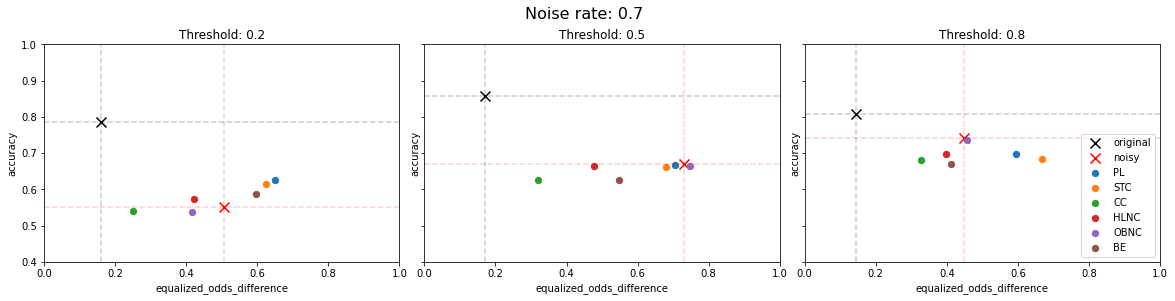

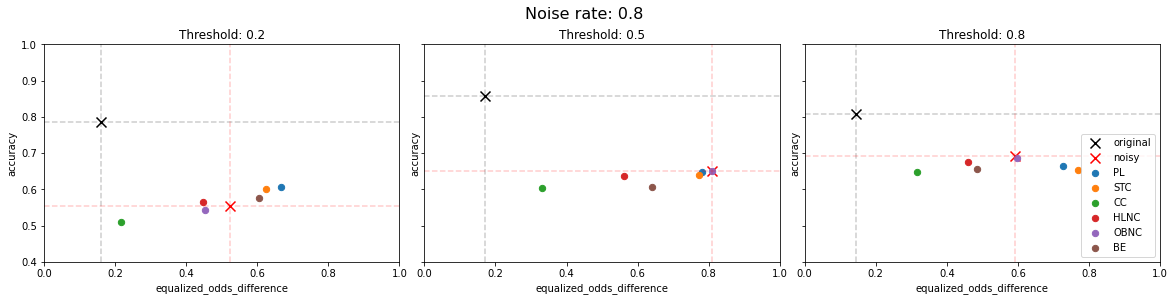

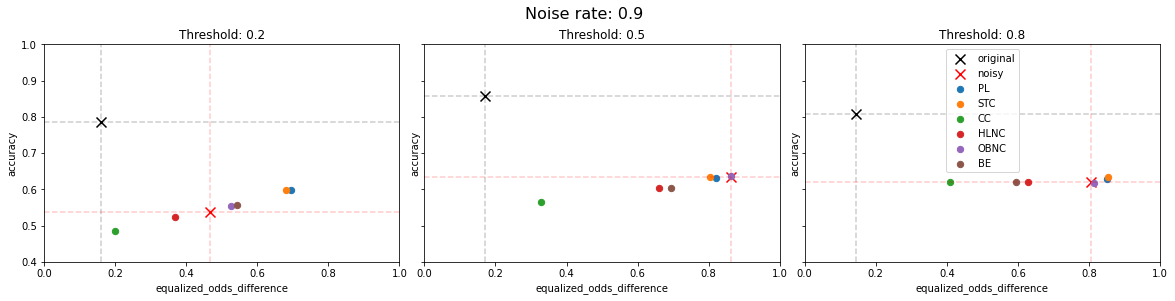

In [112]:
create_gif('bias', 'accuracy', 'equalized_odds_difference', (0, 1), (0.4, 1))

### Balanced bias

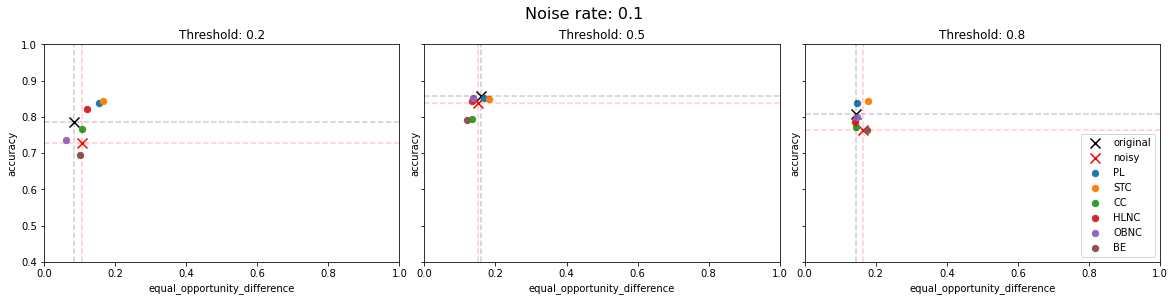

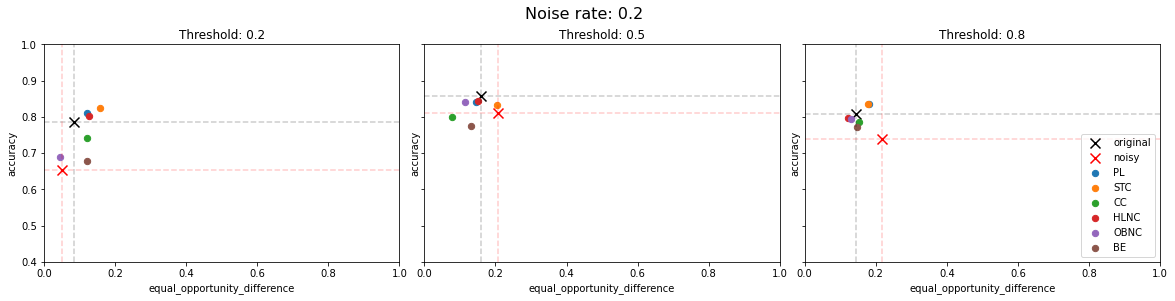

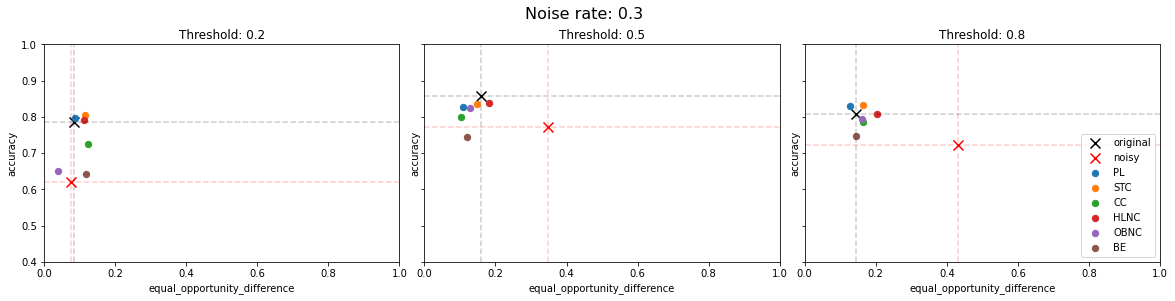

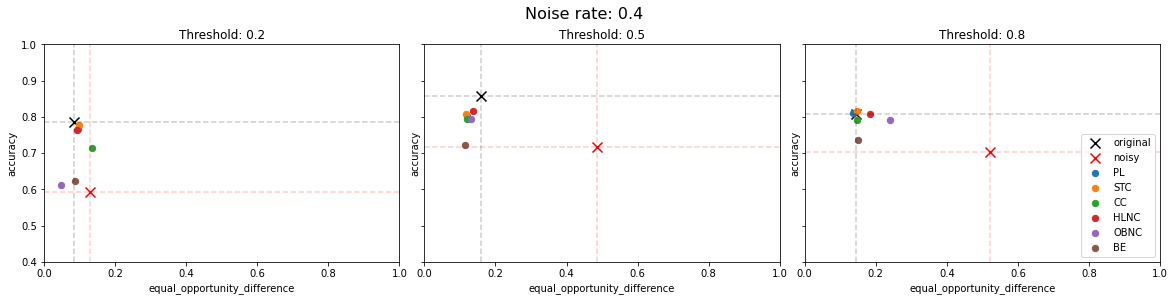

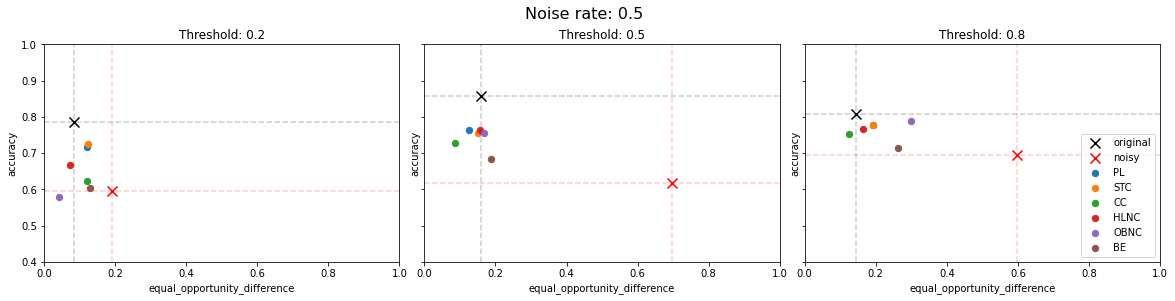

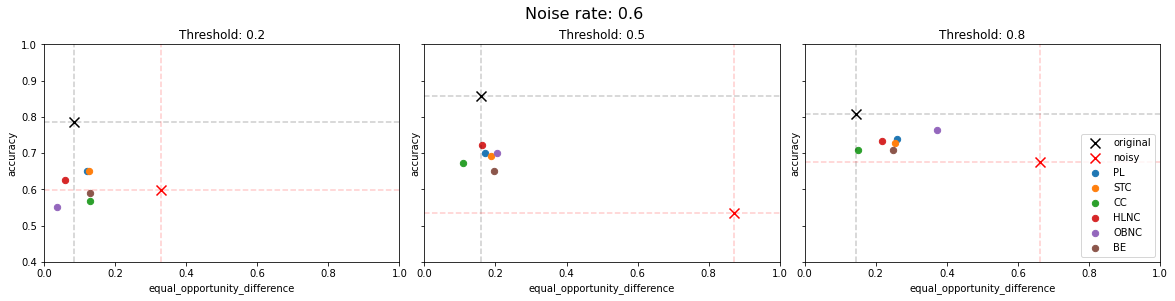

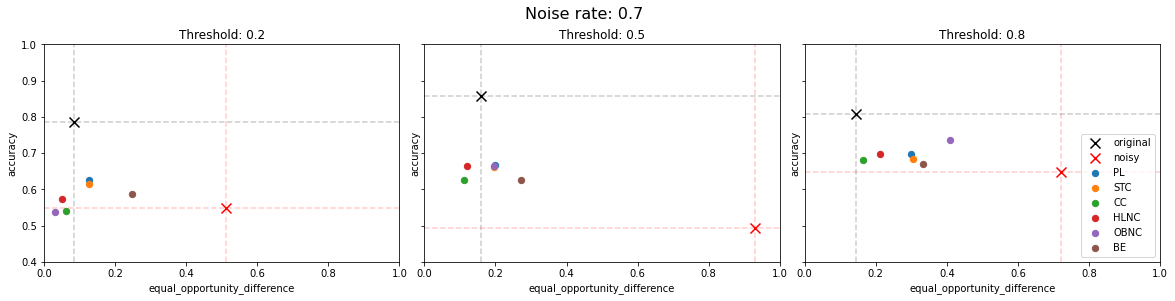

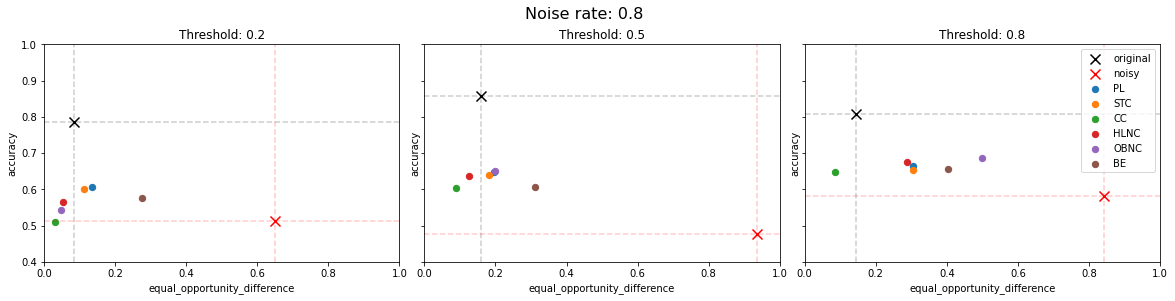

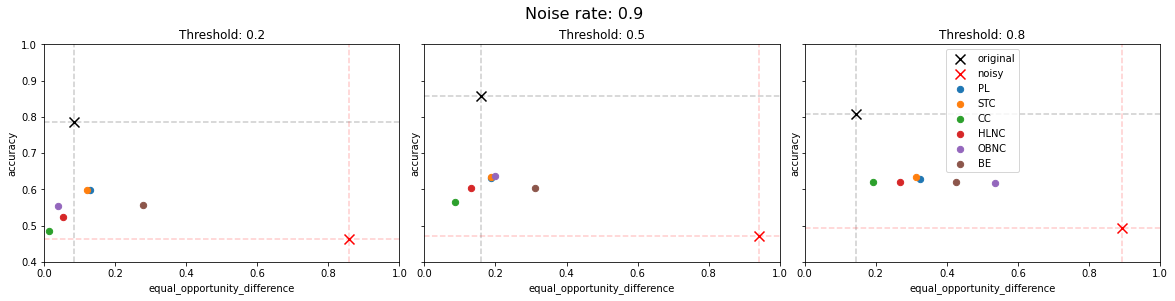

In [117]:
create_gif('balanced_bias', 'accuracy', 'equal_opportunity_difference', (0, 1), (0.4, 1))

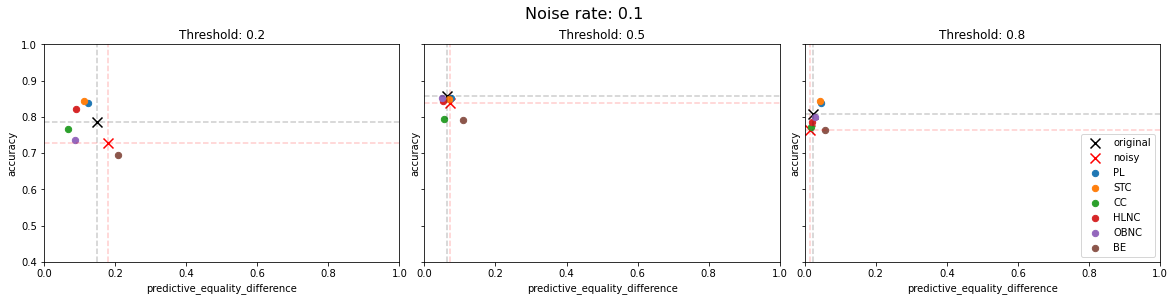

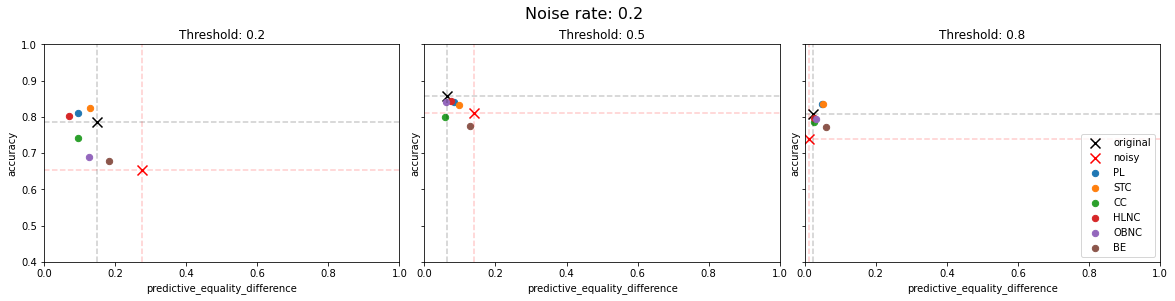

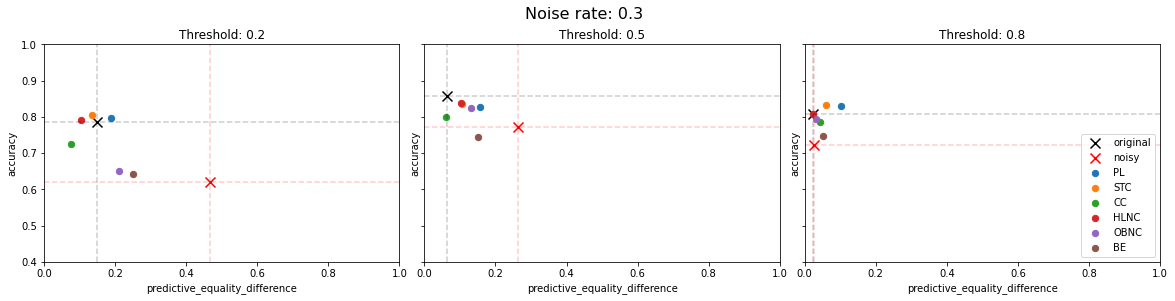

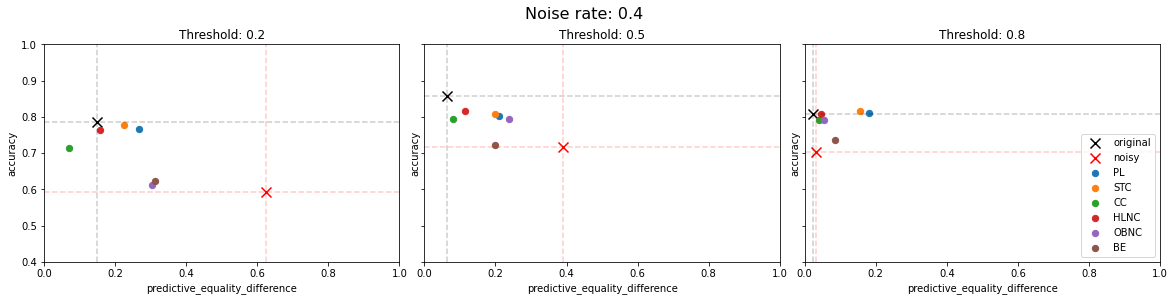

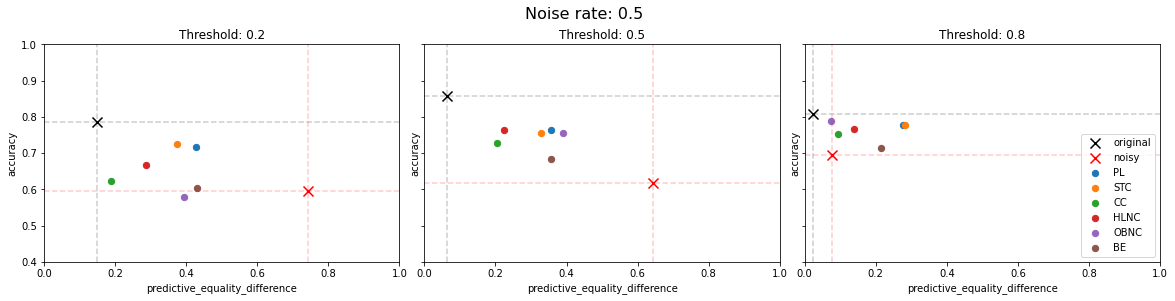

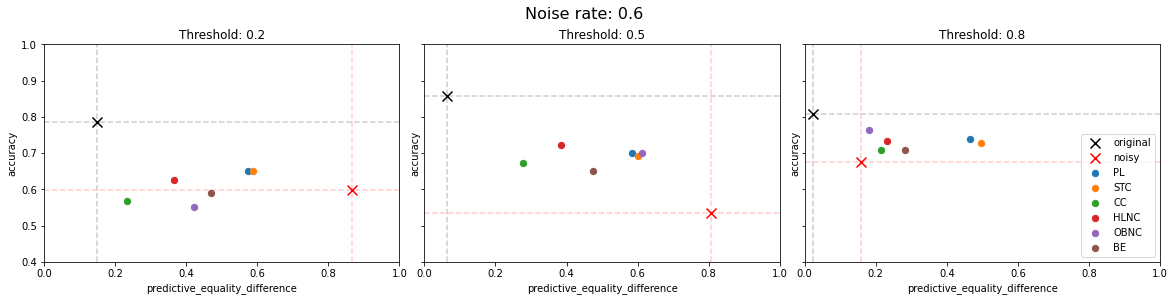

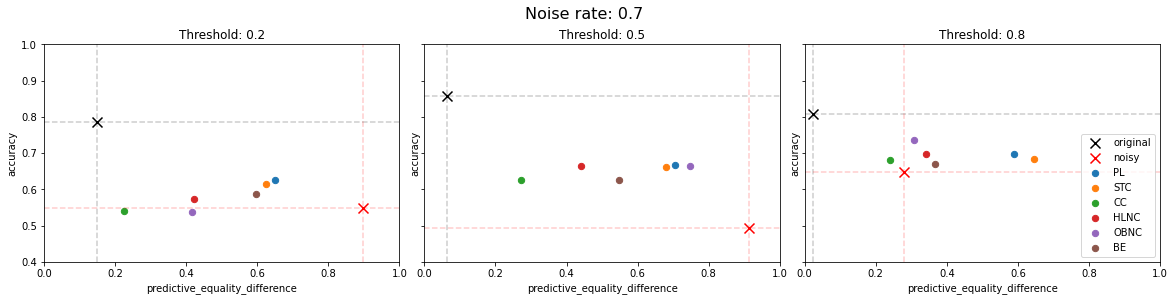

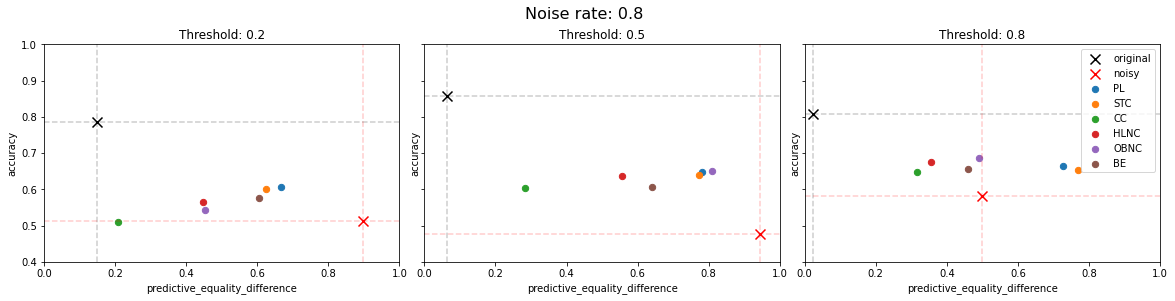

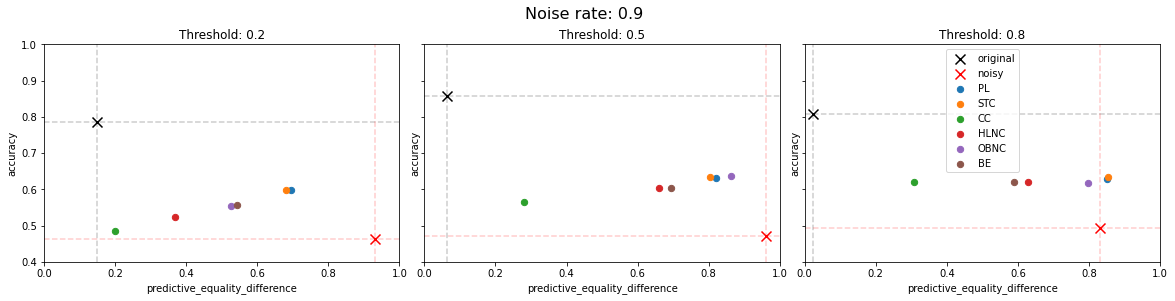

In [114]:
create_gif('balanced_bias', 'accuracy', 'predictive_equality_difference', (0, 1), (0.4, 1))

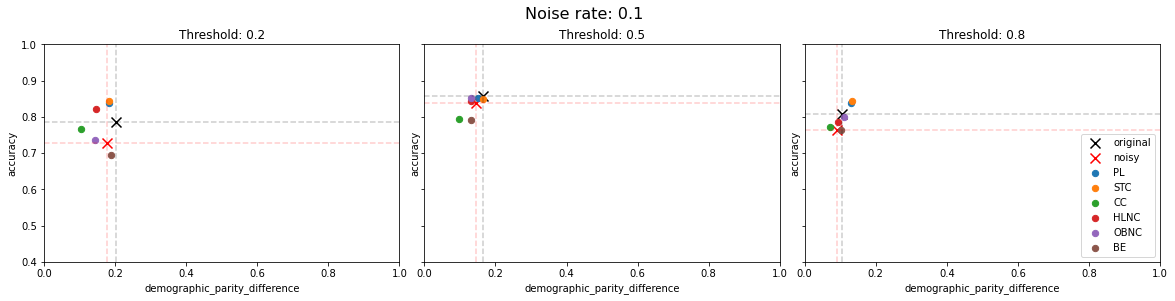

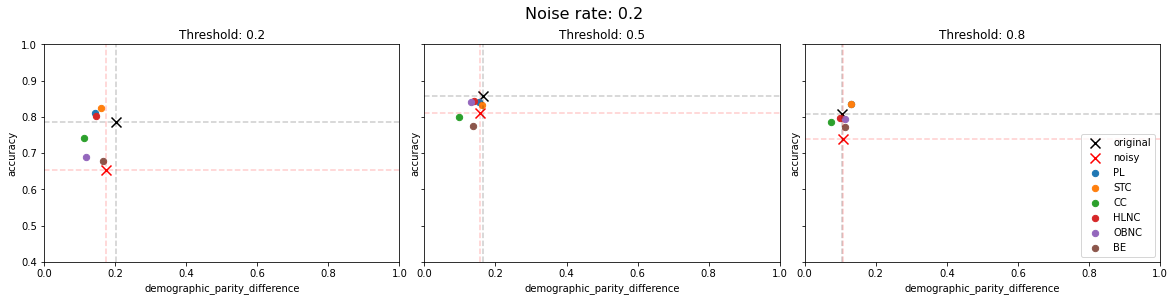

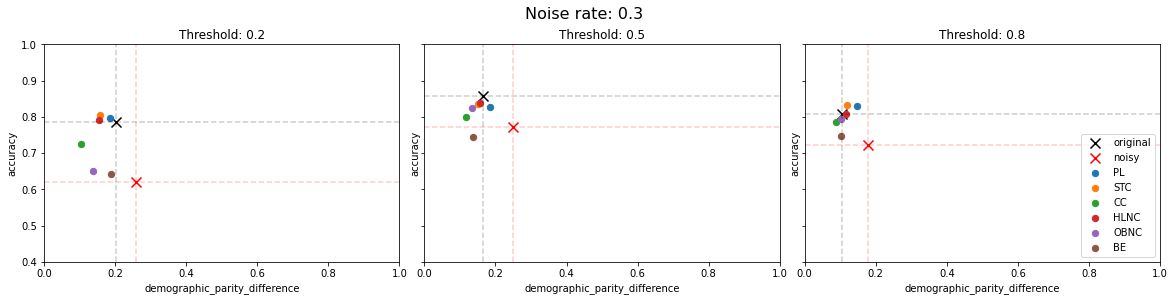

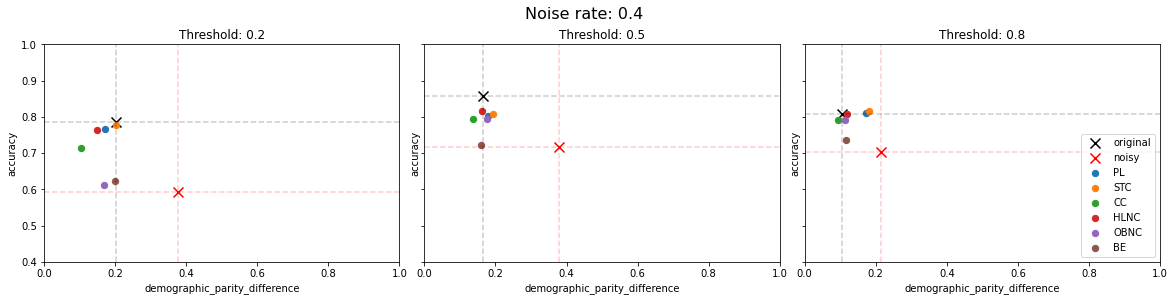

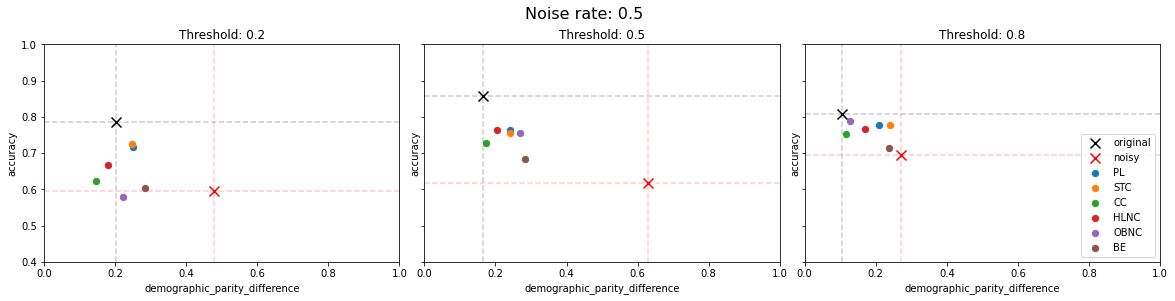

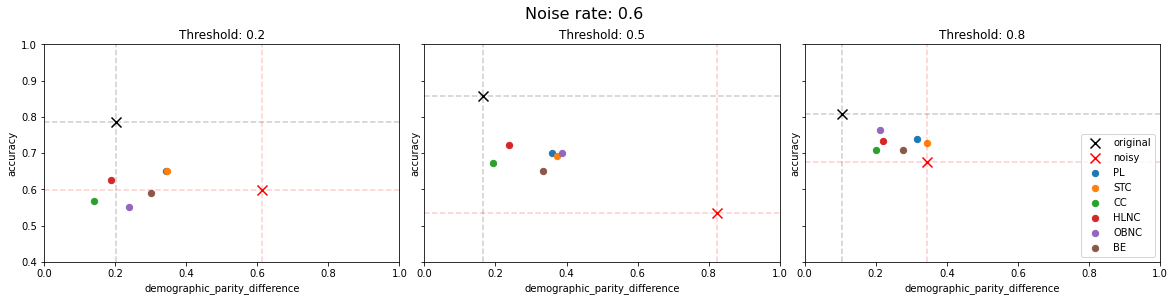

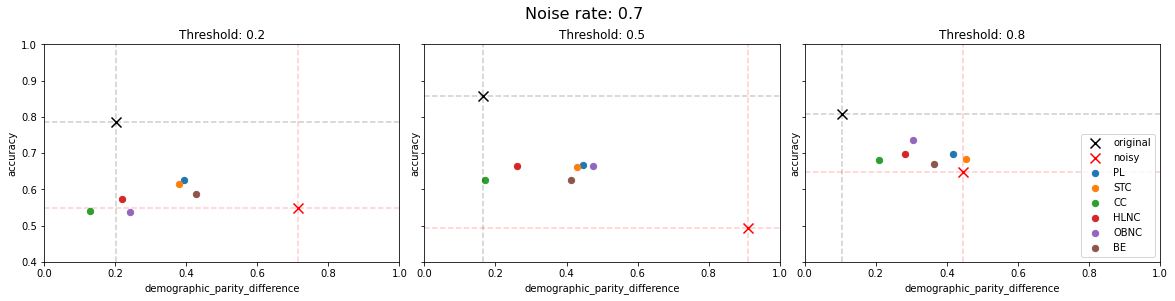

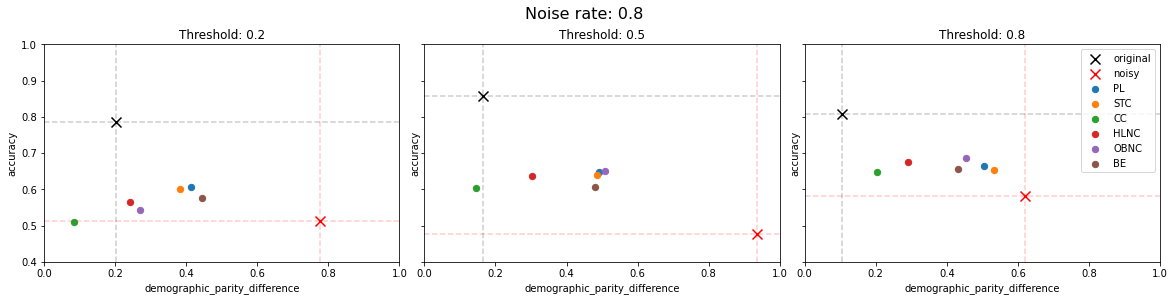

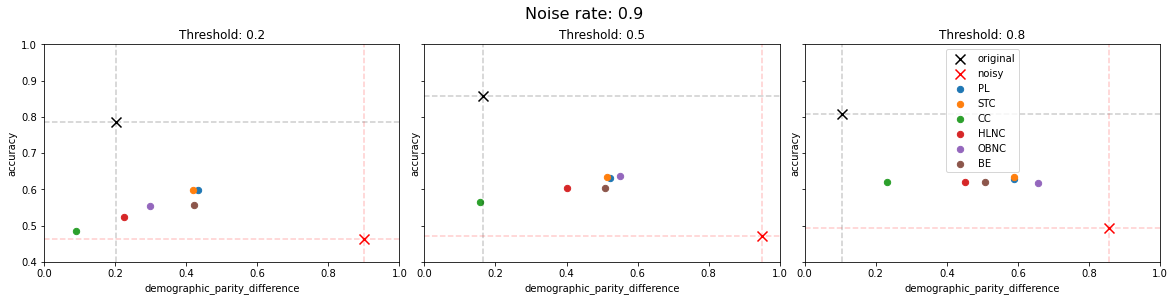

In [115]:
create_gif('balanced_bias', 'accuracy', 'demographic_parity_difference', (0, 1), (0.4, 1))

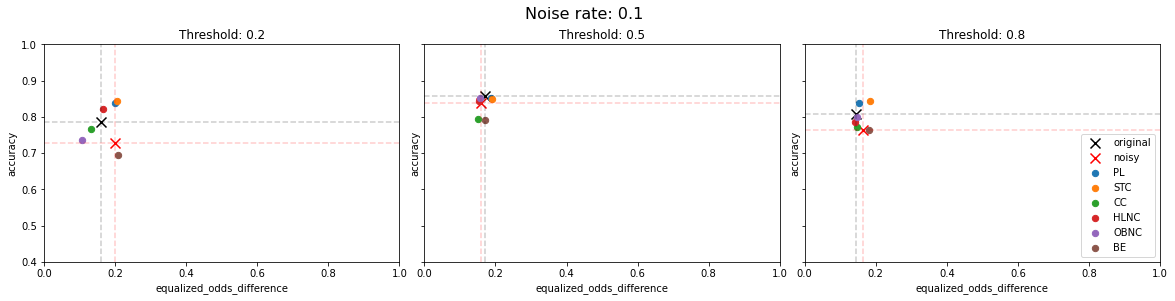

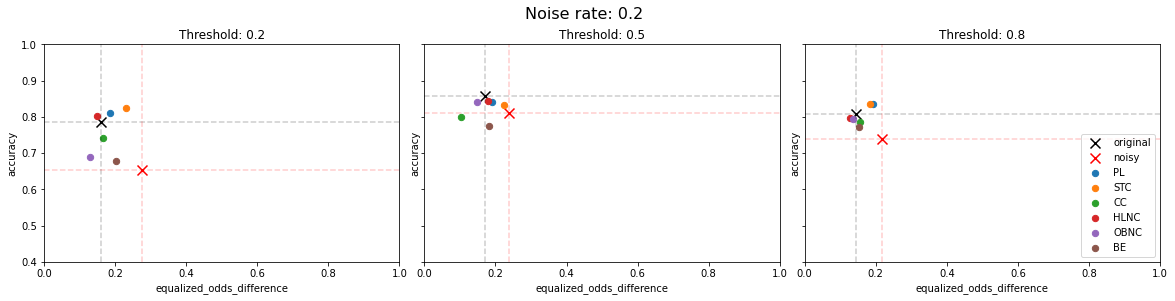

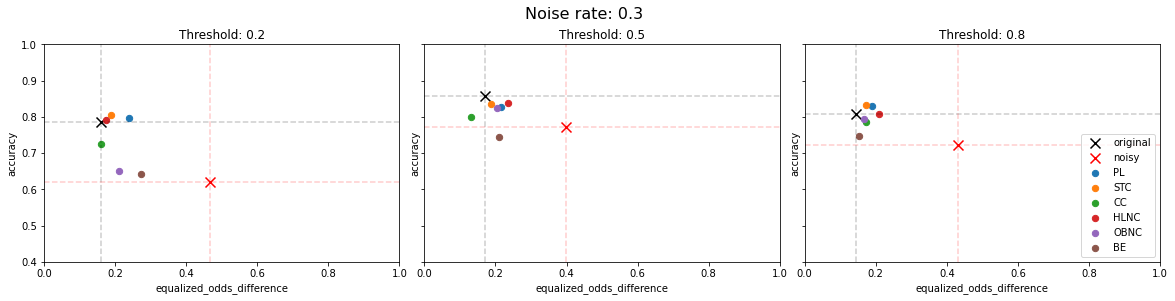

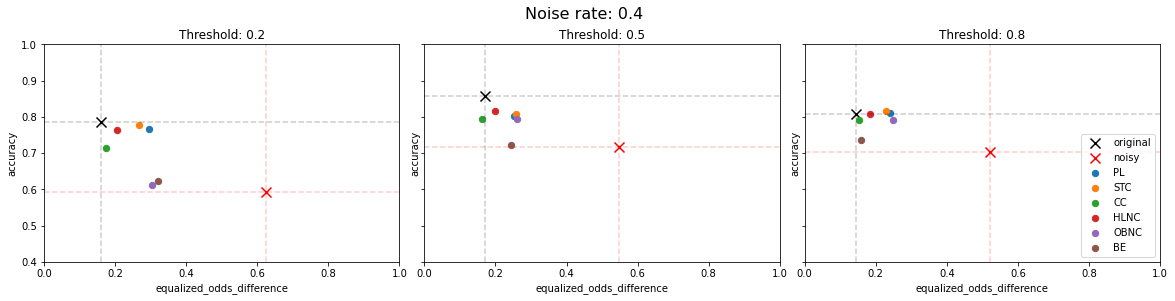

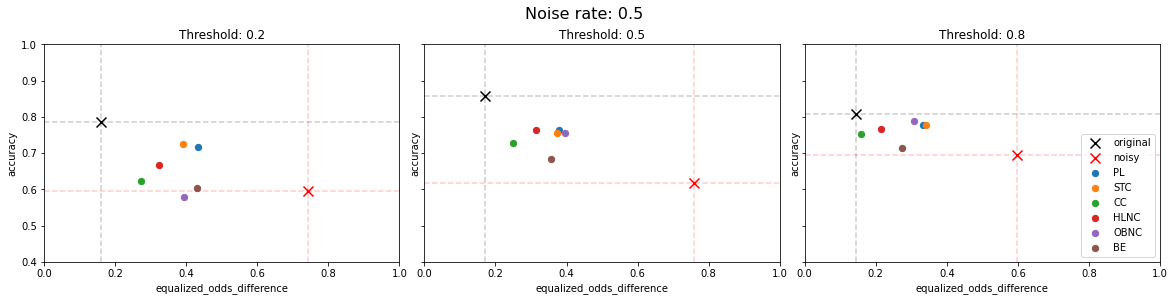

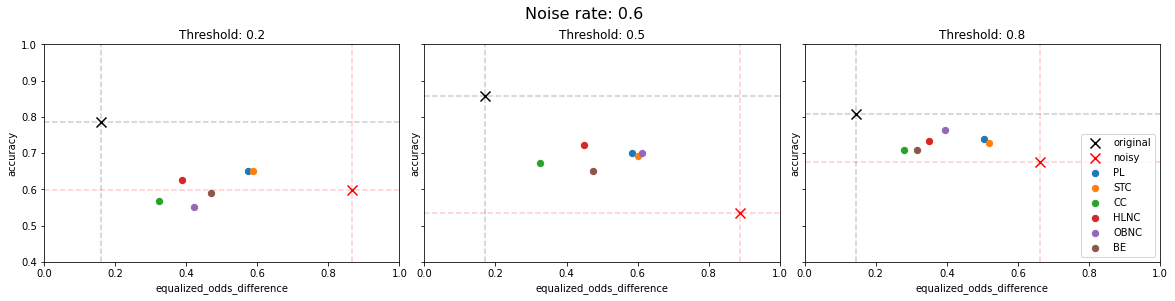

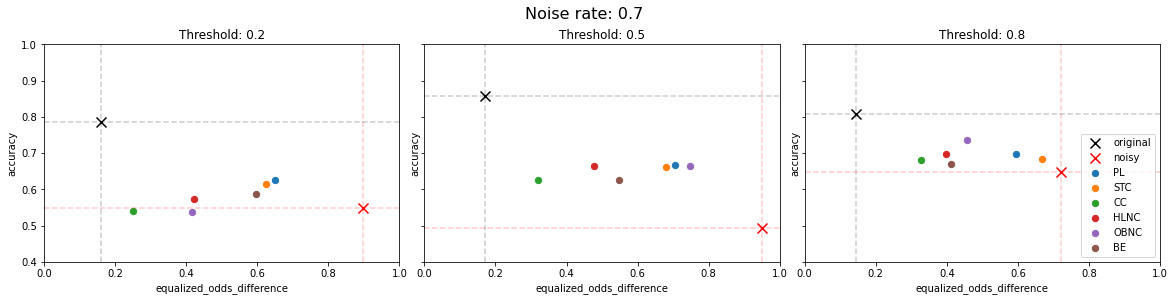

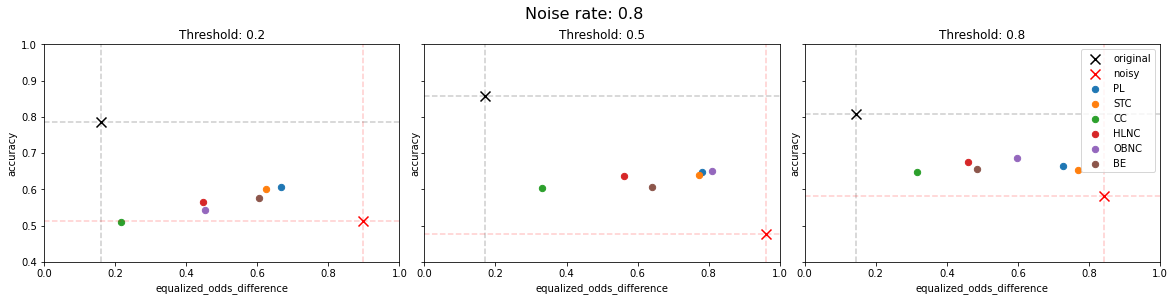

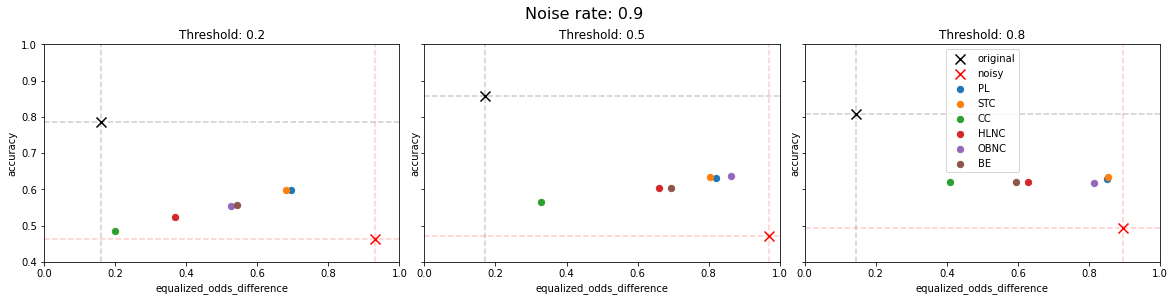

In [116]:
create_gif('balanced_bias', 'accuracy', 'equalized_odds_difference', (0, 1), (0.4, 1))